# Relation extraction with BERT

---

The goal of this notebook is to show how to use [BERT](https://arxiv.org/abs/1810.04805)
to [extract relation](https://en.wikipedia.org/wiki/Relationship_extraction) from text.

Used libraries:
- [PyTorch](https://pytorch.org/)
- [PyTorch-Lightning](https://pytorch-lightning.readthedocs.io/en/latest/)
- [Transformers](https://huggingface.co/transformers/index.html)

Used datasets:
- SemEval 2010 Task 8 - [paper](https://arxiv.org/pdf/1911.10422.pdf) - [download](https://github.com/sahitya0000/Relation-Classification/blob/master/corpus/SemEval2010_task8_all_data.zip?raw=true)
- Google IISc Distant Supervision (GIDS) - [paper](https://arxiv.org/pdf/1804.06987.pdf) - [download](https://drive.google.com/open?id=1gTNAbv8My2QDmP-OHLFtJFlzPDoCG4aI)

## Install dependencies

This project uses [Python 3.7+](https://www.python.org/downloads/release/python-378/)

In [1]:
!pip install requests==2.23.0 numpy==1.18.5 pandas==1.0.3 \
    scikit-learn==0.23.1 pytorch-lightning==0.8.4 torch==1.5.1 \
    transformers==3.0.2 sklearn==0.0 tqdm==4.45.0 neptune-client==0.4.119 \
    matplotlib==3.1.0 scikit-plot==0.3.7

     |████████████████████████████████| 304 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 769 kB 9.5 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 5.6 MB/s  eta 0:00:01
     |████████████████████████████████| 13.1 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 29.4 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 2.7 MB/s  eta 0:00:01
     |████████████████████████████████| 138 kB 34.9 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 4.2 MB/s  eta 0:00:01


  Created wheel for neptune-client: filename=neptune_client-0.4.119-py2.py3-none-any.whl size=150019 sha256=cd17ff89197bbeca853f9b6187af325a39ec0c7b067a5f6aee7bb3f2dd4e4095
  Stored in directory: /root/.cache/pip/wheels/64/3b/7e/69f84d99e2109788f757ef707b3ea51921f16891e42929eb31
  Created wheel for msgpack-python: filename=msgpack_python-0.5.6-cp37-cp37m-linux_x86_64.whl size=302590 sha256=65a05bb467749710f7f7549e495da5c7c6f2955dd930c710f5c5cd7603f7e153
  Stored in directory: /root/.cache/pip/wheels/f8/6c/02/92ebc97f3b99ad5bfc675be2c513f9cb3504fdbe338314f377
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-py3-none-any.whl size=18119 sha256=1ab5fd898982ee279da8dbf73a91e0adbe711f55f837581126f87a1877b7585e
  Stored in directory: /root/.cache/pip/wheels/f3/1d/9f/2a74caecb81b8beb9a4fbe1754203d4b7cf42ef5d39e0d2311
Successfully built neptune-client msgpack-python strict-rfc3339
ERROR: plotnine 0.7.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.1.0 which is i

## Import needed modules

In [2]:
import gc
import json
import math
import os
import shutil
import zipfile
from abc import ABC, abstractmethod
from collections import OrderedDict
from typing import TextIO, Iterable, Tuple
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
from matplotlib.figure import Figure
from pandas import DataFrame
from pytorch_lightning import LightningModule, seed_everything
from pytorch_lightning import Trainer as LightningTrainer
from pytorch_lightning.logging.neptune import NeptuneLogger
from random import randint
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, \
    roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d, shuffle
from torch import Tensor, nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, IterableDataset
from tqdm.auto import tqdm
from transformers import *

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Define constants

In [3]:
# --- Random seed ---
SEED = 2020
seed_everything(SEED)

# --- Neptune logger ---
NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYjhmNDI4YzQtMjM3Yy00NWFiLTgzNDgtNWJmODJhNjVkZjdiIn0="
NEPTUNE_PROJECT_NAME="hung/bert-relation-extraction"

# --- Directory ---
ROOT_DIR = os.path.abspath('.')
PROCESSED_DATA_DIR = os.path.join(ROOT_DIR, 'data/processed') 
METADATA_FILE_NAME = os.path.join(PROCESSED_DATA_DIR, 'metadata.json')
CHECKPOINT_DIR = os.path.join(ROOT_DIR, 'checkpoint')

KAGGLE_ENV = bool(os.getenv("KAGGLE_URL_BASE"))
LOCAL_ENV = not KAGGLE_ENV
if KAGGLE_ENV:
    # in Kaggle environment
    # 3 datasets should already been added to the notebook
    RAW_DATA_DIR = os.path.join(ROOT_DIR, '../input')
else:
    # in local environment
    RAW_DATA_DIR =  os.path.join(ROOT_DIR, 'data/raw')

# --- Datasets ---
DATASET_MAPPING = {
    'SemEval2010Task8': {
        'dir': os.path.join(RAW_DATA_DIR,'semeval2010-task-8'),
        'extract_dir': os.path.join(RAW_DATA_DIR, 'SemEval2010_task8_all_data'),
        'url': 'https://github.com/sahitya0000/Relation-Classification/'
               'blob/master/corpus/SemEval2010_task8_all_data.zip?raw=true'
    },
    'GIDS': {
        'dir': os.path.join(RAW_DATA_DIR,'gids-dataset'),
        'extract_dir': os.path.join(RAW_DATA_DIR, 'gids_data'),
        'url': 'https://drive.google.com/uc?id=1gTNAbv8My2QDmP-OHLFtJFlzPDoCG4aI&export=download'
    }
}

# change this variable to switch dataset in later tasks
DATASET_NAME = 'SemEval2010Task8'

# --- BERT ---
SUB_START_CHAR = '['
SUB_END_CHAR = ']'
OBJ_START_CHAR = '{'
OBJ_END_CHAR = '}'

# --- BERT Model ---
# See https://huggingface.co/transformers/pretrained_models.html for the full list
AVAILABLE_PRETRAINED_MODELS = [
    'distilbert-base-uncased', # 0
    'distilbert-base-cased',   # 1
    'bert-base-uncased',       # 2
    'distilgpt2',              # 3
    'gpt2',                    # 4
    'distilroberta-base',      # 5
    'roberta-base',            # 6
    'albert-base-v1',          # 7
    'albert-base-v2',          # 8
    'bert-large-uncased',      # 9
]

# change this variable to switch pretrained language model in later tasks
PRETRAINED_MODEL = AVAILABLE_PRETRAINED_MODELS[2]

# if e1 is not related to e2, should "e2 not related to e1" be added to the training set
ADD_REVERSE_RELATIONSHIP = False

## Download data

This part **CAN BE SKIPPED** if this notebook is running on Kaggle environment since the dataset has already been included.

First, we install `gdown` to download files from Google Drive

In [ ]:
!if [ -z "KAGGLE_URL_BASE" ]; then pip install gdown==3.11.1 ; else echo "gdown is not installed" ;  fi

if LOCAL_ENV:
    import gdown
else:
    print("gdown is not imported")


Some download util functions:

In [ ]:
def download_from_url(url: str, save_path: str, chunk_size: int = 2048):
    with open(save_path, "wb") as f:
        print(f"Downloading...\nFrom: {url}\nTo: {save_path}")
        response = requests.get(url, stream=True)
        for data in tqdm(response.iter_content(chunk_size=chunk_size)):
            f.write(data)

def download_from_google_drive(url: str, save_path: str):
    gdown.download(url, save_path, use_cookies=False)

def extract_zip(zip_file_path: str, extract_dir: str, remove_zip_file: bool = True):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print("Extracting to " + extract_dir)
        for member in tqdm(zip_ref.infolist()):
            zip_ref.extract(member, extract_dir)

    if remove_zip_file:
        print("Removing zip file")
        os.unlink(zip_file_path)

The download function itself:

In [ ]:
def download(dataset_name: str, dataset_url: str, dataset_dir: str, dataset_extract_dir: str, force_redownload: bool):
    print(f"\n---> Downloading dataset {dataset_name} <---")
    
    # create raw data dir
    if not os.path.exists(RAW_DATA_DIR):
        print("Creating raw data directory " + RAW_DATA_DIR)
        os.makedirs(RAW_DATA_DIR)
    
    # check data has been downloaded
    if os.path.exists(dataset_dir):
        if force_redownload:
            print(f"Removing old raw data {dataset_dir}")
            shutil.rmtree(dataset_dir)
        else:
            print(f"Directory {dataset_dir} exists, skip downloading.")
            return


    # download
    tmp_file_path = os.path.join(RAW_DATA_DIR, dataset_name + '.zip')
    if urlparse(dataset_url).netloc == 'drive.google.com':
        download_from_google_drive(dataset_url, tmp_file_path)
    else:
        download_from_url(dataset_url, tmp_file_path)

    # unzip
    extract_zip(tmp_file_path, RAW_DATA_DIR)

    # rename
    os.rename(dataset_extract_dir, dataset_dir)

Download all datasets:

In [ ]:
def download_all_dataset():
    for dataset_name, dataset_info in DATASET_MAPPING.items():
        download(
            dataset_name,
            dataset_url=dataset_info['url'],
            dataset_dir=dataset_info['dir'],
            dataset_extract_dir=dataset_info['extract_dir'],
            force_redownload=False
        )

if LOCAL_ENV:
    download_all_dataset()
else:
    print("Skip downloading")

## Preprocess

First, we define a custom label encoder. What this label encoder offers but `sklearn.preprocessing.LabelEncoder` fails
to provide:
- Order preservation: labels will be encoded in order they appear in the dataset. Labels appears earlier will have
  smaller id. We need this to ensure the `no relation` class always becomes `0`
- Multiple fit: `sklearn.preprocessing.LabelEncoder` forgets what is fit in the last time `fit` is called while our
  encoder keeps adding new labels to existing ones. This is useful when we process large dataset in batches.

In [4]:
class OrdinalLabelEncoder:
    def __init__(self, init_labels=None):
        if init_labels is None:
            init_labels = []
        self.mapping = OrderedDict({l: i for i, l in enumerate(init_labels)})

    @property
    def classes_(self):
        return list(self.mapping.keys())

    def fit_transform(self, y):
        return self.fit(y).transform(y)

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        new_classes = pd.Series(y).unique()
        for cls in new_classes:
            if cls not in self.mapping:
                self.mapping[cls] = len(self.mapping)
        return self

    def transform(self, y):
        y = column_or_1d(y, warn=True)
        return [self.mapping[value] for value in y]
    

Preprocessor classes:

In [5]:
class AbstractPreprocessor(ABC):
    DATASET_NAME = ''
    VAL_DATA_PROPORTION = 0.2
    NO_RELATION_LABEL = ''

    def __init__(self, tokenizer: PreTrainedTokenizer):
        self.tokenizer = tokenizer
        self.SUB_START_ID, self.SUB_END_ID, self.OBJ_START_ID, self.OBJ_END_ID \
            = tokenizer.convert_tokens_to_ids([SUB_START_CHAR, SUB_END_CHAR, OBJ_START_CHAR, OBJ_END_CHAR])

    def preprocess_data(self, reprocess: bool):
        print(f"\n---> Preprocessing {self.DATASET_NAME} dataset <---")
        
        # create processed data dir
        if not os.path.exists(PROCESSED_DATA_DIR):
            print("Creating processed data directory " + PROCESSED_DATA_DIR)
            os.makedirs(PROCESSED_DATA_DIR)

        # stop preprocessing if file existed
        json_file_names = [self.get_dataset_file_name(k) for k in ('train', 'val', 'test')]
        existed_files = [fn for fn in json_file_names if os.path.exists(fn)]
        if existed_files:
            file_text = "- " + "\n- ".join(existed_files)
            if not reprocess:
                print("The following files already exist:")
                print(file_text)
                print("Preprocessing is skipped. See option --reprocess.")
                return
            else:
                print("The following files will be overwritten:")
                print(file_text)

        self._preprocess_data()
        self._create_secondary_data_files()

        print("---> Done ! <---")

    @abstractmethod
    def _preprocess_data(self):
        pass

    def _create_secondary_data_files(self):
        """
        From the primary data file, create a data file with binary labels
        and a data file with only sentences classified as "related"
        """

        with open(METADATA_FILE_NAME) as f:
            root_metadata = json.load(f)
            metadata = root_metadata[self.DATASET_NAME]

        related_only_count = {
            'train': 0,
            'val': 0,
            'test': 0,
        }

        for key in ['train', 'test', 'val']:
            print(f"Creating secondary files for {key} data")

            origin_file = open(self.get_dataset_file_name(key))
            bin_file = open(self.get_dataset_file_name(f'{key}_binary'), "w")
            related_file = open(self.get_dataset_file_name(f'{key}_related_only'), "w")

            total = metadata[f'{key}_size']

            for line in tqdm(origin_file, total=total):
                data = json.loads(line)
                if data['label'] != 0:
                    related_only_count[key] += 1
                    data['label'] -= 1 # label in "related_only" files is 1 less than the original label
                    related_file.write(json.dumps(data) + "\n")
                    data['label'] = 1 # in binary dataset, all "related" classes have label 1
                    bin_file.write(json.dumps(data) + "\n")
                else:
                    bin_file.write(json.dumps(data) + "\n")

            origin_file.close()
            bin_file.close()
            related_file.close()

        print("Updating metadata.json")
        for key in ['train', 'test', 'val']:
            metadata[f'{key}_related_only_size'] = related_only_count[key]
        root_metadata[self.DATASET_NAME] = metadata
        with open(METADATA_FILE_NAME, "w") as f:
            json.dump(root_metadata, f, indent=4)

    def _find_sub_obj_pos(self, input_ids_list: Iterable) -> DataFrame:
        """
        Find subject and object position in a sentence
        """
        sub_start_pos = [self._index(s, self.SUB_START_ID) + 1 for s in input_ids_list]
        sub_end_pos = [self._index(s, self.SUB_END_ID, sub_start_pos[i]) for i, s in enumerate(input_ids_list)]
        obj_start_pos = [self._index(s, self.OBJ_START_ID) + 1 for s in input_ids_list]
        obj_end_pos = [self._index(s, self.OBJ_END_ID, obj_start_pos[i]) for i, s in enumerate(input_ids_list)]
        return DataFrame({
            'sub_start_pos': sub_start_pos,
            'sub_end_pos': sub_end_pos,
            'obj_start_pos': obj_start_pos,
            'obj_end_pos': obj_end_pos,
        })

    @staticmethod
    def _index(lst: list, ele: int, start: int = 0) -> int:
        """
        Find an element in a list. Returns -1 if not found instead of raising an exception.
        """
        try:
            return lst.index(ele, start)
        except ValueError:
            return -1

    def _remove_invalid_sentences(self, data: DataFrame) -> DataFrame:
        """
        Remove sentences without subject/object or whose subject/object
        is beyond the maximum length the model supports
        """
        seq_max_len = self.tokenizer.model_max_length
        return data.loc[
            (data['sub_end_pos'] < seq_max_len)
            & (data['obj_end_pos'] < seq_max_len)
            & (data['sub_end_pos'] > -1)
            & (data['obj_end_pos'] > -1)
        ]

    @staticmethod
    def _get_label_mapping(le: LabelEncoder):
        """
        Returns a mapping from id to label and vise versa from the label encoder
        """
        # all labels
        id_to_label = dict(enumerate(le.classes_))
        label_to_id = {v: k for k, v in id_to_label.items()}

        # for the related_only dataset
        # ignore id 0, which represent no relation
        id_to_label_related_only = {k - 1: v for k, v in id_to_label.items() if k != 0}
        label_to_id_related_only = {v: k for k, v in id_to_label_related_only.items()}

        return {
            'id_to_label': id_to_label,
            'label_to_id': label_to_id,
            'id_to_label_related_only': id_to_label_related_only,
            'label_to_id_related_only': label_to_id_related_only,            
        }

    @staticmethod
    def _append_data_to_file(data: DataFrame, file: TextIO):
        """Append data from a dataframe to an opened file"""
        lines = ""
        for _, row in data.iterrows():
            lines += row.to_json() + "\n"
        file.write(lines)

    def _save_metadata(self, metadata: dict):
        """Save metadata to metadata.json"""
        # create metadata file
        if not os.path.exists(METADATA_FILE_NAME):
            print(f"Create metadata file at {METADATA_FILE_NAME}")
            with open(METADATA_FILE_NAME, 'w') as f:
                f.write("{}\n")

        # add metadata
        print("Saving metadata")
        with open(METADATA_FILE_NAME) as f:
            root_metadata = json.load(f)
        with open(METADATA_FILE_NAME, 'w') as f:
            root_metadata[self.DATASET_NAME] = metadata
            json.dump(root_metadata, f, indent=4)

    def _get_label_encoder(self) -> OrdinalLabelEncoder:
        """
        Factory method for label encoder
        Ensure that "no relation" has id 0
        """
        return OrdinalLabelEncoder([self.NO_RELATION_LABEL])

    @classmethod
    def get_dataset_file_name(cls, key: str) -> str:
        return os.path.join(PROCESSED_DATA_DIR, f'{cls.DATASET_NAME.lower()}_{key}.json')


class SemEval2010Task8Preprocessor(AbstractPreprocessor):
    DATASET_NAME = 'SemEval2010Task8'
    NO_RELATION_LABEL = 'Other'
    RAW_TRAIN_FILE_NAME = os.path.join(DATASET_MAPPING['SemEval2010Task8']['dir'],
                                       'SemEval2010_task8_training/TRAIN_FILE.TXT')
    RAW_TEST_FILE_NAME = os.path.join(DATASET_MAPPING['SemEval2010Task8']['dir'],
                                      'SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT')
    RAW_TRAIN_DATA_SIZE = 8000
    RAW_TEST_DATA_SIZE = 2717

    def _preprocess_data(self):
        print("Processing training data")
        train_data = self._get_data_from_file(
            self.RAW_TRAIN_FILE_NAME,
            self.RAW_TRAIN_DATA_SIZE
        )

        print("Processing test data")
        test_data = self._get_data_from_file(
            self.RAW_TEST_FILE_NAME,
            self.RAW_TEST_DATA_SIZE
        )

        print("Encoding labels to integers")
        le = self._get_label_encoder()
        train_data['label'] = le.fit_transform(train_data['label'])
        test_data['label'] = le.transform(test_data['label'])

        print("Splitting train & validate data")
        train_data, val_data = train_test_split(train_data, shuffle=True, random_state=SEED)

        print("Saving to json files")
        with open(self.get_dataset_file_name('train'), 'w') as f:
            self._append_data_to_file(train_data, f)
        with open(self.get_dataset_file_name('val'), 'w') as f:
            self._append_data_to_file(val_data, f)
        with open(self.get_dataset_file_name('test'), 'w') as f:
            self._append_data_to_file(test_data, f)

        self._save_metadata({
            'train_size': len(train_data),
            'val_size': len(val_data),
            'test_size': len(test_data),
            'no_relation_label': self.NO_RELATION_LABEL,
            **self._get_label_mapping(le)
        })

    def _get_data_from_file(self, file_name: str, dataset_size: int, reverse: bool = ADD_REVERSE_RELATIONSHIP) -> DataFrame:
        raw_sentences = []
        labels = []
        with open(file_name) as f:
            for _ in tqdm(range(dataset_size)):
                sent = f.readline()
                label, sub, obj = self._process_label(f.readline())
                labels.append(label)
                raw_sentences.append(self._process_sentence(sent, sub, obj))
                if label == 'Other' and reverse:
                    labels.append(label)
                    raw_sentences.append(self._process_sentence(sent, obj, sub))
                f.readline()
                f.readline()
        tokens = self.tokenizer(raw_sentences, truncation=True, padding='max_length')
        data = DataFrame(tokens.data)
        data['label'] = labels
        sub_obj_position = self._find_sub_obj_pos(data['input_ids'])
        data = pd.concat([data, sub_obj_position], axis=1)
        data = self._remove_invalid_sentences(data)
        return data

    @staticmethod
    def _process_sentence(sentence: str, sub: int, obj: int) -> str:
        return sentence.split("\t")[1][1:-2] \
            .replace(f"<e{sub}>", SUB_START_CHAR) \
            .replace(f"</e{sub}>", SUB_END_CHAR) \
            .replace(f"<e{obj}>", OBJ_START_CHAR) \
            .replace(f"</e{obj}>", OBJ_END_CHAR)

    @staticmethod
    def _process_label(label: str) -> Tuple[str, int, int]:
        label = label.strip()
        if label == 'Other':
            return label, 1, 2
        nums = list(filter(str.isdigit, label))
        return label, int(nums[0]), int(nums[1])


class GIDSPreprocessor(AbstractPreprocessor):
    DATASET_NAME = 'GIDS'
    RAW_TRAIN_FILE_NAME = os.path.join(DATASET_MAPPING['GIDS']['dir'], 'gids_train.json')
    RAW_VAL_FILE_NAME = os.path.join(DATASET_MAPPING['GIDS']['dir'], 'gids_dev.json')
    RAW_TEST_FILE_NAME = os.path.join(DATASET_MAPPING['GIDS']['dir'], 'gids_test.json')
    TRAIN_SIZE = 11297
    VAL_SIZE = 1864
    TEST_SIZE = 5663
    PROCESS_BATCH_SIZE = 2**12
    NO_RELATION_LABEL = 'NA'

    @staticmethod
    def _replace_word_once(arr: list, element: str, replacement: str):
        """
        Replace a word in a list of words by another
        Also take care of punctuations
        """
        for i, e in enumerate(arr):
            # exact match
            if e == element:
                arr[i] = replacement
                return
            # check for elements that ends with a special character
            if e[:-1] == element and e[-1] in ',.?!;:':
                arr[i] = replacement + e[-1]
                return

    def _process_batch(self, le: LabelEncoder, in_file: TextIO) -> DataFrame:
        """
        Process one batch
        """
        raw_sentences = []
        labels = []

        for _ in range(self.PROCESS_BATCH_SIZE):
            dt = in_file.readline()
            if dt == "": break # EOF
            dt = json.loads(dt)

            # add subject markup
            sub = dt['sub']  # TODO keep _ or not?
            obj = dt['obj']
            new_sub = SUB_START_CHAR + ' ' + sub.replace("_", "") + ' ' + SUB_END_CHAR
            new_obj = OBJ_START_CHAR + ' ' +  obj.replace("_", "") + ' ' + OBJ_END_CHAR
            self._replace_word_once(dt['sent'], sub, new_sub)
            self._replace_word_once(dt['sent'], obj, new_obj)
            raw_sentences.append(" ".join(dt['sent']))
            labels.append(dt['rel'])

        if not raw_sentences:
            return DataFrame()

        tokens = self.tokenizer(raw_sentences, truncation=True, padding='max_length')
        data = DataFrame(tokens.data)
        data['label'] = le.fit_transform(labels)
        sub_obj_position = self._find_sub_obj_pos(data['input_ids'])
        data = pd.concat([data, sub_obj_position], axis=1)
        data = self._remove_invalid_sentences(data)
        return data

    def _process_file(self, le: LabelEncoder, in_file_name: str, out_file_name: str, data_size: int) -> int:
        """
        Process a file in batches
        Return the total data size
        """
        total_data_size = 0
        batch_count = math.ceil(data_size / self.PROCESS_BATCH_SIZE)

        with open(in_file_name) as in_file, open(out_file_name, 'w') as out_file:
            for _ in tqdm(range(batch_count)):
                data = self._process_batch(le, in_file)
                self._append_data_to_file(data, out_file)
                total_data_size += len(data)

        return total_data_size

    def _preprocess_data(self):
        le = self._get_label_encoder()
        
        print("Process train dataset")
        actual_train_size = self._process_file(
            le,
            self.RAW_TRAIN_FILE_NAME,
            self.get_dataset_file_name('train'),
            self.TRAIN_SIZE
        )

        print("Process val dataset")
        actual_val_size = self._process_file(
            le,
            self.RAW_VAL_FILE_NAME,
            self.get_dataset_file_name('val'),
            self.VAL_SIZE
        )
        
        print("Process test dataset")
        actual_test_size = self._process_file(
            le, 
            self.RAW_TEST_FILE_NAME, 
            self.get_dataset_file_name('test'),
            self.TEST_SIZE
        )

        self._save_metadata({
            'train_size': actual_train_size,
            'val_size': actual_val_size,
            'test_size': actual_test_size,
            'no_relation_label': self.NO_RELATION_LABEL,
            **self._get_label_mapping(le)
        })


def get_preprocessor_class(dataset_name: str = DATASET_NAME):
    return globals()[f'{dataset_name}Preprocessor']
        
def get_preprocessor(dataset_name: str = DATASET_NAME)-> AbstractPreprocessor:
    tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL, use_fast=True)
    # some tokenizer, like GPTTokenizer, doesn't have pad_token
    # in this case, we use eos token as pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        
    preprocessors_class = get_preprocessor_class(dataset_name)
    return preprocessors_class(tokenizer)

In [6]:
preprocessor = get_preprocessor()
preprocessor.preprocess_data(reprocess=True)



---> Preprocessing SemEval2010Task8 dataset <---
Creating processed data directory /kaggle/working/data/processed
Processing training data



Processing test data



Encoding labels to integers
Splitting train & validate data
Saving to json files
Create metadata file at /kaggle/working/data/processed/metadata.json
Saving metadata
Creating secondary files for train data



Creating secondary files for test data



Creating secondary files for val data



Updating metadata.json
---> Done ! <---


## Model

### Dataset

In [7]:
class GenericDataset(IterableDataset):
    """A generic dataset for train/val/test data for SemEval, GIDS & NYT"""

    def __init__(self, dataset_name: str, subset: str, batch_size: int, label_transform: str):
        assert subset in ['train', 'val', 'test']
        assert label_transform in ['none', 'binary', 'related_only']

        file_name = subset if label_transform == 'none' \
            else f'{subset}_{label_transform}'

        preprocessor_class = get_preprocessor_class()
        with open(METADATA_FILE_NAME) as f:
            metadata = json.load(f)[dataset_name]

        size = metadata[f'{subset}_related_only_size'] \
            if label_transform is 'related_only' \
            else metadata[f'{subset}_size']

        self.subset = subset
        self.batch_size = batch_size
        self.length = math.ceil(size / batch_size)
        self.file = open(preprocessor_class.get_dataset_file_name(file_name))

    def __del__(self):
        if self.file:
            self.file.close()

    def __iter__(self):
        # https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e
        data = [json.loads(line) for line in self.file]
        if self.subset != "test":
            data = sorted(data, key=lambda x: sum(x['attention_mask']))

        new_data = []

        while len(data) > 0:
            if self.subset == "test" or len(data) < self.batch_size:
                idx = 0
            else:
                idx = randint(0, len(data) - self.batch_size)
            batch = data[idx:idx + self.batch_size]
            max_len = max([sum(b['attention_mask']) for b in batch])

            for b in batch:
                input_data = {}
                for k, v in b.items():
                    if k != 'label':
                        if isinstance(v, list):
                            input_data[k] = torch.tensor(v[:max_len])
                        else:
                            input_data[k] = torch.tensor(v)
                label = torch.tensor(b['label'])
                new_data.append((input_data, label))

            del data[idx:idx + self.batch_size]

        yield from new_data
    
    def __len__(self):
        return self.length

    def as_batches(self):
        input_data = []
        label = []
        
        def create_batch():
            return (
                {k: torch.stack([x[k] for x in input_data]).cuda() for k in input_data[0].keys()},
                torch.tensor(label).cuda()
            )
        
        for ip, l in self:
            input_data.append(ip)
            label.append(l)
            if len(input_data) == self.batch_size:
                yield create_batch()
                input_data.clear()
                label.clear()

        yield create_batch()

### Models

In [23]:
class BaseClassifier(LightningModule, ABC):
    """
    Base class of all classifiers
    """

    def __init__(self, dataset_label_transform: str):
        super().__init__()
        assert dataset_label_transform in ['none', 'binary', 'related_only']
        self.dataset_label_transform = dataset_label_transform

    @abstractmethod
    def loss_function(self, logits: Tensor, label: Tensor) -> Tensor:
        """
        Calculate the loss of the model
        It MUST take care of the last activation layer
        """
        pass
    
    @abstractmethod
    def log_metrics(self, epoch_type: str, logits: Tensor, label: Tensor) -> dict:
        pass
   
    def train_dataloader(self) -> DataLoader:
        return self.__get_dataloader('train')

    def val_dataloader(self) -> DataLoader:
        return self.__get_dataloader('val')

    def test_dataloader(self) -> DataLoader:
        return self.__get_dataloader('test')

    def __get_dataloader(self, subset: str) -> DataLoader:
        batch_size = self.hparams.batch_size
        dataset = GenericDataset(
            self.hparams.dataset_name,
            subset, 
            batch_size, 
            self.dataset_label_transform
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=1
        )

    def configure_optimizers(self):
        optimizer = AdamW(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = LambdaLR(optimizer, lambda epoch: self.hparams.decay_lr_speed[epoch])
        return [optimizer], [scheduler]
    
    def training_step(self, batch: Tuple[dict, Tensor], batch_nb: int) -> dict:
        input_data, label = batch
        logits = self(**input_data)

        loss = self.loss_function(logits, label)
        log = {'train_loss': loss}

        return {'loss': loss, 'log': log}

    def __eval_step(self, batch:  Tuple[dict, Tensor]) -> dict:
        input_data, label = batch
        logits = self(**input_data)

        return {
            'logits': logits,
            'label': label,
        }
    
    def validation_step(self, batch: Tuple[dict, Tensor], batch_nb: int) -> dict:
        return self.__eval_step(batch)
    
    def test_step(self, batch: Tuple[dict, Tensor], batch_nb: int) -> dict:
        return self.__eval_step(batch)

    def __eval_epoch_end(self, epoch_type: str, outputs: Iterable[dict]) -> dict:
        assert epoch_type in ['test', 'val']
        
        logits = torch.cat([x['logits'] for x in outputs]).cpu()
        label = torch.cat([x['label'] for x in outputs]).cpu()
        
        logs = self.log_metrics(epoch_type, logits, label)
        
        return {'progress_bar': logs}
    
    def validation_epoch_end(self, outputs: Iterable[dict]) -> dict:
        return self.__eval_epoch_end('val', outputs)

    def test_epoch_end(self, outputs: Iterable[dict]) -> dict:
        return self.__eval_epoch_end('test', outputs)
    
    @staticmethod
    def plot_confusion_matrix(predicted_label: Tensor, label: Tensor) -> Figure:
        result = confusion_matrix(label, predicted_label)
        display = ConfusionMatrixDisplay(result)
        fig, ax = plt.subplots(figsize=(16, 12))
        display.plot(cmap=plt.cm.get_cmap("Blues"), ax=ax)
        return fig
    
    def log_confusion_matrix(self, prefix: str, predicted_label: Tensor, label: Tensor):
        fig = self.plot_confusion_matrix(predicted_label, label)
        self.logger.experiment.log_image(f'{prefix}_confusion_matrix', fig)


class MulticlassClassifier(BaseClassifier, ABC):
    """
    Base class for multiclass classifiers
    """

    def loss_function(self, logits: Tensor, label: Tensor)-> Tensor:
        return F.cross_entropy(logits, label)

    @staticmethod
    def logits_to_label(logits: Tensor) -> Tensor:
        return torch.argmax(logits, dim=-1)

    def log_metrics(self, epoch_type: str, logits: Tensor, label: Tensor) -> dict:
        predicted_label = self.logits_to_label(logits)
        self.log_confusion_matrix(epoch_type, predicted_label, label)

        logs = {
            f'{epoch_type}_avg_loss': float(self.loss_function(logits, label)),
            f'{epoch_type}_acc': accuracy_score(label, predicted_label),
            f'{epoch_type}_pre_weighted': precision_score(label, predicted_label, average='weighted'),
            f'{epoch_type}_rec_weighted': recall_score(label, predicted_label, average='weighted'),
            f'{epoch_type}_f1_weighted': f1_score(label, predicted_label, average='weighted'),
            f'{epoch_type}_pre_macro': precision_score(label, predicted_label, average='macro'),
            f'{epoch_type}_rec_macro': recall_score(label, predicted_label, average='macro'),
            f'{epoch_type}_f1_macro': f1_score(label, predicted_label, average='macro'),
        }

        for k, v in logs.items():
            self.logger.experiment.log_metric(k, v)

        return logs


class StandardClassifier(MulticlassClassifier):
    """
    A classifier that can recognize the "not related" as well as other relations
    """

    def __init__(self, pretrained_language_model, dataset_name, batch_size, learning_rate, decay_lr_speed,
                 linear_size, dropout_p, activation_function, weight_decay):
        super().__init__(dataset_label_transform="none")
        self.save_hyperparameters()
        self.test_proposed_answer = None

        with open(METADATA_FILE_NAME) as f:
            num_classes = len(json.load(f)[dataset_name]['label_to_id'])

        self.language_model = AutoModel.from_pretrained(pretrained_language_model)
        config = self.language_model.config
        self.max_seq_len = config.max_position_embeddings
        self.hidden_size = config.hidden_size

        self.dropout = nn.Dropout(p=dropout_p)
        self.linear = nn.Linear(self.hidden_size, linear_size)
        self.activation_function = getattr(nn, activation_function)()
        self.linear_output = nn.Linear(linear_size, num_classes)
#         self.linear_output = nn.Linear(self.hidden_size, num_classes)

    def forward(self, sub_start_pos, sub_end_pos,
                obj_start_pos, obj_end_pos, *args, **kwargs) -> Tensor:
        language_model_output = self.language_model(*args, **kwargs)
        if isinstance(language_model_output, tuple):
            language_model_output = language_model_output[0]

        x = torch.mean(language_model_output, dim=1)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        logits = self.linear_output(x)

        return logits

    def log_metrics(self, epoch_type: str, logits: Tensor, label: Tensor)-> dict:
        if epoch_type == 'test':
            self.test_proposed_answer = self.logits_to_label(logits).tolist()
        return super().log_metrics(epoch_type, logits, label)


class BinaryClassifier(BaseClassifier):
    """
    A binary classifier that picks out "not-related" sentences
    """

    def __init__(self, pretrained_language_model, dataset_name, batch_size, learning_rate, decay_lr_speed,
                 dropout_p, activation_function, weight_decay, cls_linear_size, sub_obj_linear_size):
        super().__init__(dataset_label_transform="binary")
        self.save_hyperparameters()
        self.thresholds = {}
        
        self.obj_stream = torch.cuda.Stream()
        self.sub_stream = torch.cuda.Stream()

        self.language_model = AutoModel.from_pretrained(pretrained_language_model)
        config = self.language_model.config
        self.max_seq_len = config.max_position_embeddings
        self.hidden_size = config.hidden_size
        
        self.cls_linear = nn.Linear(config.hidden_size, cls_linear_size)
        self.sub_linear = nn.Linear(config.hidden_size, sub_obj_linear_size)
        self.obj_linear = nn.Linear(config.hidden_size, sub_obj_linear_size)
        
        self.linear = nn.Linear(cls_linear_size + 2 * sub_obj_linear_size, 1)
        
        self.dropout = nn.Dropout(p=dropout_p)
        self.activation_function = getattr(nn, activation_function)()

    @staticmethod
    def yhat_to_label(y_hat: Tensor, threshold: float) -> Tensor:
        return (y_hat > threshold).long()

    def loss_function(self, logits: Tensor, label: Tensor) -> Tensor:
        return F.binary_cross_entropy_with_logits(logits, label.float())

    def forward(self, sub_start_pos, sub_end_pos,
                obj_start_pos, obj_end_pos, *args, **kwargs) -> Tensor:
        language_model_output = self.language_model(*args, **kwargs)
        if isinstance(language_model_output, tuple):
            language_model_output = language_model_output[0]
        
        bz = language_model_output.shape[0]
        
        with torch.cuda.stream(self.sub_stream):
            sub = [torch.mean(language_model_output[i, sub_start_pos[i]:sub_end_pos[i]], dim=0) for i in range(bz)]
            sub = self.dropout(torch.stack(sub))
            sub = self.activation_function(self.sub_linear(sub))
        
        with torch.cuda.stream(self.obj_stream):
            obj = [torch.mean(language_model_output[i, obj_start_pos[i]:obj_end_pos[i]], dim=0) for i in range(bz)]
            obj = self.dropout(torch.stack(obj))
            obj = self.activation_function(self.obj_linear(obj))
        
        cls = self.dropout(language_model_output[:, 0])
        cls = self.activation_function(self.cls_linear(cls))
        
        torch.cuda.synchronize()
        
        x = torch.cat([cls, sub, obj], dim=1)
        x = self.dropout(x)
        logits = self.linear(x).reshape(-1)
        
        return logits
    
    def log_metrics(self, epoch_type: str, logits: Tensor, label: Tensor) -> dict:
        y_hat = torch.sigmoid(logits)
        
        if epoch_type == 'val':
            self.__find_thresholds(y_hat, label)
        
        self.__log_output_distribution(epoch_type, y_hat, label)
        
        logs = {
            f'{epoch_type}_avg_loss': float(self.loss_function(logits, label)),
            f'{epoch_type}_roc_auc': self.__roc_auc_score(label, y_hat),
        }
        
        for criteria, threshold in self.thresholds.items():
            prefix = f"{epoch_type}_{criteria}"
            predicted_label = self.yhat_to_label(y_hat, threshold)
            self.log_confusion_matrix(prefix, predicted_label, label)
            
            logs[f'{prefix}_acc'] = accuracy_score(label, predicted_label)
            logs[f'{prefix}_pre'] = precision_score(label, predicted_label, average='binary')
            logs[f'{prefix}_rec'] = recall_score(label, predicted_label, average='binary')
            logs[f'{prefix}_f1'] = f1_score(label, predicted_label, average='binary')

        for k, v in logs.items():
            self.logger.experiment.log_metric(k, v)
            
        return logs
    
    @staticmethod
    def __roc_auc_score(label: Tensor, y_hat: Tensor) -> float:
        try:
            return roc_auc_score(label, y_hat)
        except ValueError:
            return 0
    
    def __find_thresholds(self, y_hat: Tensor, label: Tensor):
        """
        Find 3 classification thresholds based on 3 criteria:
        - The one that yields highest accuracy
        - The "best point" in the ROC curve
        - The one that yields highest f1
        The results are logged and stored in self.threshold
        """
        # best accuracy
        best_acc = 0
        best_acc_threshold = None
        for y in y_hat:
            y_predicted = self.yhat_to_label(y_hat, threshold=y)
            acc = accuracy_score(label, y_predicted)
            if best_acc < acc:
                best_acc = acc
                best_acc_threshold = y
        self.thresholds['best_acc'] = best_acc_threshold

        # ROC curve
        # https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        fpr, tpr, thresholds = roc_curve(label, y_hat)
        gmeans = tpr * (1 - fpr)
        ix = np.argmax(gmeans)
        self.thresholds['best_roc'] = thresholds[ix]
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.plot([0,1], [0,1], linestyle='--', label='No Skill')
        ax.plot(fpr, tpr, marker='.', label='Logistic')
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()
        self.logger.experiment.log_image('roc_curve', fig)

        # precision recall curve
        # https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
        pre, rec, thresholds = precision_recall_curve(label, y_hat)
        f1s = 2 * pre * rec / (pre + rec)
        ix = np.argmax(f1s)
        self.thresholds['best_f1'] = thresholds[ix]

        fig, ax = plt.subplots(figsize=(16, 12))
        no_skill = len(label[label == 1]) / len(label)
        ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        ax.plot(rec, pre, marker='.', label='Logistic')
        ax.scatter(rec[ix], pre[ix], marker='o', color='black', label='Best F1')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        self.logger.experiment.log_image('pre_rec_curve', fig)

        # log thresholds
        for k, v in self.thresholds.items():
            self.logger.experiment.log_metric(f'threshold_{k}', v)

    def __log_output_distribution(self, epoch_type: str, y_hat: Tensor, label: Tensor):
        """
        Log the distribution of the model output and 3 thresholds with log scale and linear scale
        """
        y_neg = y_hat[label == 0].numpy()
        y_pos = y_hat[label == 1].numpy()

        for scale in ['linear', 'log']:
            fig, ax = plt.subplots(figsize=(16, 12))
            ax.set_yscale(scale)
            ax.hist([y_neg, y_pos], stacked=True, bins=50, label=["No relation", "Related"])
            ylim = ax.get_ylim()
            for k, v in self.thresholds.items():
                ax.plot([v, v], ylim, linestyle='--', label=f'{k} threshold')
            ax.legend()
            self.logger.experiment.log_image(f'{epoch_type}_distribution_{scale}_scale', fig)
        

class RelationClassifier(MulticlassClassifier):
    """
    A classifier that recognizes relations except for "not-related"
    """

    def __init__(self, pretrained_language_model, dataset_name, batch_size, learning_rate, decay_lr_speed,
                 dropout_p, activation_function, weight_decay, cls_linear_size, sub_obj_linear_size):
        super().__init__(dataset_label_transform="related_only")
        self.save_hyperparameters()

        with open(METADATA_FILE_NAME) as f:
            num_classes = len(json.load(f)[dataset_name]['label_to_id_related_only'])
        
        self.obj_stream = torch.cuda.Stream()
        self.sub_stream = torch.cuda.Stream()

        self.language_model = AutoModel.from_pretrained(pretrained_language_model)
        config = self.language_model.config
        self.max_seq_len = config.max_position_embeddings
        self.hidden_size = config.hidden_size
        
        self.cls_linear = nn.Linear(config.hidden_size, cls_linear_size)
        self.sub_linear = nn.Linear(config.hidden_size, sub_obj_linear_size)
        self.obj_linear = nn.Linear(config.hidden_size, sub_obj_linear_size)
        
        self.linear = nn.Linear(cls_linear_size + 2 * sub_obj_linear_size, num_classes)
        
        self.dropout = nn.Dropout(p=dropout_p)
        self.activation_function = getattr(nn, activation_function)()
    
    def forward(self, sub_start_pos, sub_end_pos,
                obj_start_pos, obj_end_pos, *args, **kwargs) -> Tensor:
        
        language_model_output = self.language_model(*args, **kwargs)
        if isinstance(language_model_output, tuple):
            language_model_output = language_model_output[0]
        
        bz = language_model_output.shape[0]
        
        with torch.cuda.stream(self.sub_stream):
            sub = [torch.mean(language_model_output[i, sub_start_pos[i]:sub_end_pos[i]], dim=0) for i in range(bz)]
            sub = self.dropout(torch.stack(sub))
            sub = self.activation_function(self.sub_linear(sub))
        
        with torch.cuda.stream(self.obj_stream):
            obj = [torch.mean(language_model_output[i, obj_start_pos[i]:obj_end_pos[i]], dim=0) for i in range(bz)]
            obj = self.dropout(torch.stack(obj))
            obj = self.activation_function(self.obj_linear(obj))
        
        cls = self.dropout(language_model_output[:, 0])
        cls = self.activation_function(self.cls_linear(cls))
        
        torch.cuda.synchronize()
        
        x = torch.cat([cls, sub, obj], dim=1)
        x = self.dropout(x)
        logits = self.linear(x)
        
        return logits

## The official scorer

Some datasets comes with official scorers. We will define them in this session.

In [9]:
class AbstractScorer(ABC):
    def __init__(self, experiment_no: int, logger):
        self.experiment_no = experiment_no
        self.logger = logger

    @abstractmethod
    def score(self, proposed_answer: dict):
        pass

class SemEval2010Task8Scorer(AbstractScorer):
    RESULT_FILE = "semeval2010_task8_official_score_{}_{}.txt"
    PROPOSED_ANSWER_FILE = "semeval2010_task8_proposed_answer.txt"
    SCORER = os.path.join(DATASET_MAPPING['SemEval2010Task8']['dir'], "SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl")
    FORMAT_CHECKER = os.path.join(DATASET_MAPPING['SemEval2010Task8']['dir'], "SemEval2010_task8_scorer-v1.2/semeval2010_task8_format_checker.pl")
    ANSWER_KEY = os.path.join(DATASET_MAPPING['SemEval2010Task8']['dir'], "SemEval2010_task8_testing_keys/TEST_FILE_KEY.TXT")

    def score(self, proposed_answer: dict):
        # write test_result to file
        with open(METADATA_FILE_NAME) as f:
            metadata = json.load(f)
            id_to_label = {int(k): v for k, v in metadata[DATASET_NAME]['id_to_label'].items()}

        for criteria, answer in proposed_answer.items():
            result_file = self.RESULT_FILE.format(self.experiment_no, criteria)
            i = 8001
            with open(self.PROPOSED_ANSWER_FILE, "w") as f:
                for r in answer:
                    f.write(f"{i}\t{id_to_label[r]}\n")
                    i += 1

            # call the official scorer
            os.system(f"perl {self.FORMAT_CHECKER} {self.PROPOSED_ANSWER_FILE}")
            os.system(f"perl {self.SCORER} {self.PROPOSED_ANSWER_FILE} {self.ANSWER_KEY} > {result_file}")

            # log the official score
            with open(result_file) as f:
                result = f.read()
                print(f">>> Classifier with criteria: {criteria} <<<")
                print(result)
                print("\n\n")
            self.logger.experiment.log_artifact(result_file)

def get_official_scorer(experiment_no: int, logger, dataset_name: str = DATASET_NAME) -> AbstractScorer:
    return globals().get(dataset_name + "Scorer")(experiment_no, logger)

## Claiming back memory & disk space

See [this](https://stackoverflow.com/a/61707643/7342188) and [this](https://stackoverflow.com/a/57860310/7342188)

In [ ]:
1 / 0

In [ ]:
trainer = classifier = rel_trainer = rel_classifier = bin_trainer = bin_classifier = None
gc.collect()
torch.cuda.empty_cache()

## Training standard classifier

In [24]:
GPUS = 1
MIN_EPOCHS = MAX_EPOCHS = 6

BATCH_SIZE = 4
LEARNING_RATE = 2e-05
LEARNING_RATE_DECAY_SPEED = [1, 1, 0.75, 0.5, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01]

LINEAR_SIZE = 256

DROPOUT_P = 0.2
ACTIVATION_FUNCTION = "Tanh"
WEIGHT_DECAY = 0.01 # default = 0.01

https://ui.neptune.ai/hung/bert-relation-extraction/e/BERT-275


NeptuneLogger will work in online mode


--------- EXPERIMENT 0 ---------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params
--------------------------------------------------
0 | language_model      | BertModel | 109 M 
1 | dropout             | Dropout   | 0     
2 | linear              | Linear    | 196 K 
3 | activation_function | Tanh      | 0     
4 | linear_output       | Linear    | 4 K   


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.8976812661023187,
 'test_avg_loss': 0.46535879373550415,
 'test_f1_macro': 0.8458762291793861,
 'test_f1_weighted': 0.8962551208589531,
 'test_pre_macro': 0.8459730550273077,
 'test_pre_weighted': 0.8979721379366816,
 'test_rec_macro': 0.8489692787216967,
 'test_rec_weighted': 0.8976812661023187}
--------------------------------------------------------------------------------

>>> Classifier with criteria: standard <<<
<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 126    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    0    0    7 |  134    0  134
 C-E2 |   0  190    0    2    0  

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


--------- EXPERIMENT 1 ---------



  | Name                | Type      | Params
--------------------------------------------------
0 | language_model      | BertModel | 109 M 
1 | dropout             | Dropout   | 0     
2 | linear              | Linear    | 196 K 
3 | activation_function | Tanh      | 0     
4 | linear_output       | Linear    | 4 K   


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.8962090541037909,
 'test_avg_loss': 0.45672816038131714,
 'test_f1_macro': 0.849722142698591,
 'test_f1_weighted': 0.8958244044511355,
 'test_pre_macro': 0.8523955100029691,
 'test_pre_weighted': 0.8964119603958112,
 'test_rec_macro': 0.848651976071005,
 'test_rec_weighted': 0.8962090541037909}
--------------------------------------------------------------------------------

>>> Classifier with criteria: standard <<<
<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 129    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    0    0    4 |  134    0  134
 C-E2 |   0  191    0    2    0    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


--------- EXPERIMENT 2 ---------



  | Name                | Type      | Params
--------------------------------------------------
0 | language_model      | BertModel | 109 M 
1 | dropout             | Dropout   | 0     
2 | linear              | Linear    | 196 K 
3 | activation_function | Tanh      | 0     
4 | linear_output       | Linear    | 4 K   


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.8932646301067354,
 'test_avg_loss': 0.45242348313331604,
 'test_f1_macro': 0.8441588171438278,
 'test_f1_weighted': 0.8924882579478742,
 'test_pre_macro': 0.8404786112006831,
 'test_pre_weighted': 0.8931679480941765,
 'test_rec_macro': 0.849145976076914,
 'test_rec_weighted': 0.8932646301067354}
--------------------------------------------------------------------------------

>>> Classifier with criteria: standard <<<
<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 130    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    0    0    3 |  134    0  134
 C-E2 |   0  192    0    0    0   

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


--------- EXPERIMENT 3 ---------



  | Name                | Type      | Params
--------------------------------------------------
0 | language_model      | BertModel | 109 M 
1 | dropout             | Dropout   | 0     
2 | linear              | Linear    | 196 K 
3 | activation_function | Tanh      | 0     
4 | linear_output       | Linear    | 4 K   


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.8917924181082075,
 'test_avg_loss': 0.4642152488231659,
 'test_f1_macro': 0.8408829190831272,
 'test_f1_weighted': 0.8908124079601121,
 'test_pre_macro': 0.8420782615927551,
 'test_pre_weighted': 0.8915901290565182,
 'test_rec_macro': 0.8416744001732813,
 'test_rec_weighted': 0.8917924181082075}
--------------------------------------------------------------------------------

>>> Classifier with criteria: standard <<<
<<< (2*9+1)-WAY EVALUATION (USING DIRECTIONALITY)>>>:

Confusion matrix:
        C-E1 C-E2 C-W1 C-W2 C-C1 C-C2 E-D1 E-D2 E-O1 E-O2 I-A1 I-A2 M-C1 M-C2 M-T1 M-T2 P-P1 P-P2  _O_ <-- classified as
      +-----------------------------------------------------------------------------------------------+ -SUM- skip ACTUAL
 C-E1 | 128    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    0    0    5 |  134    0  134
 C-E2 |   0  191    0    1    0   

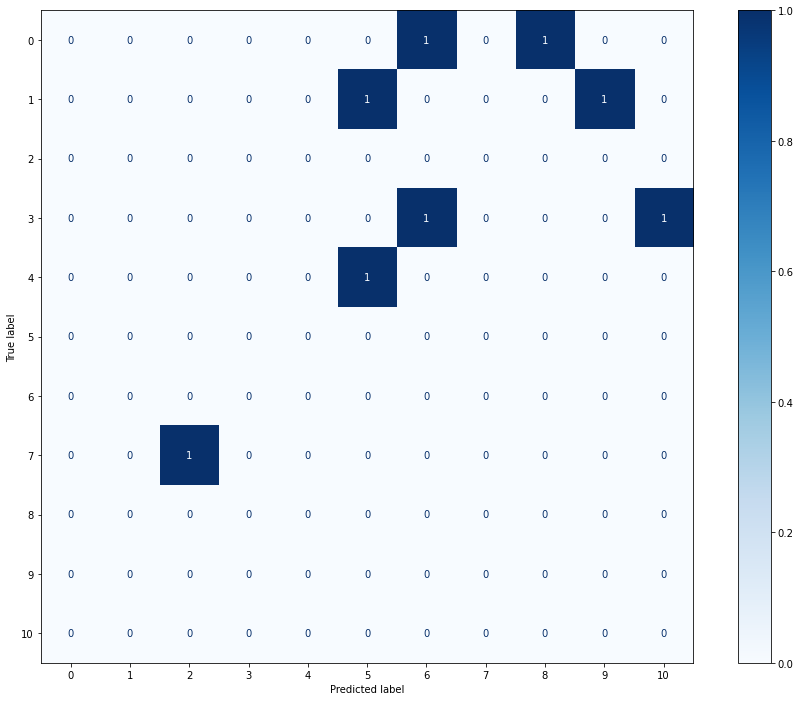

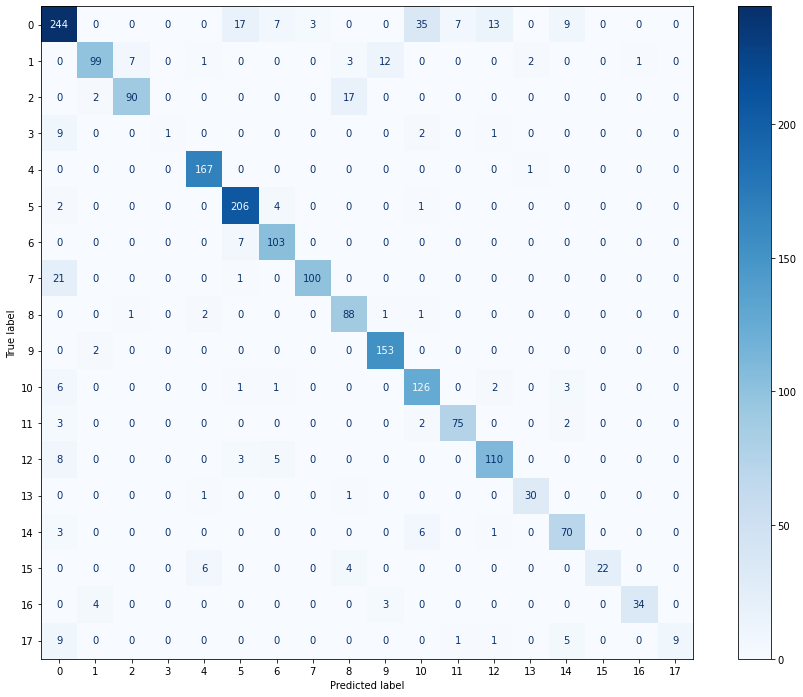

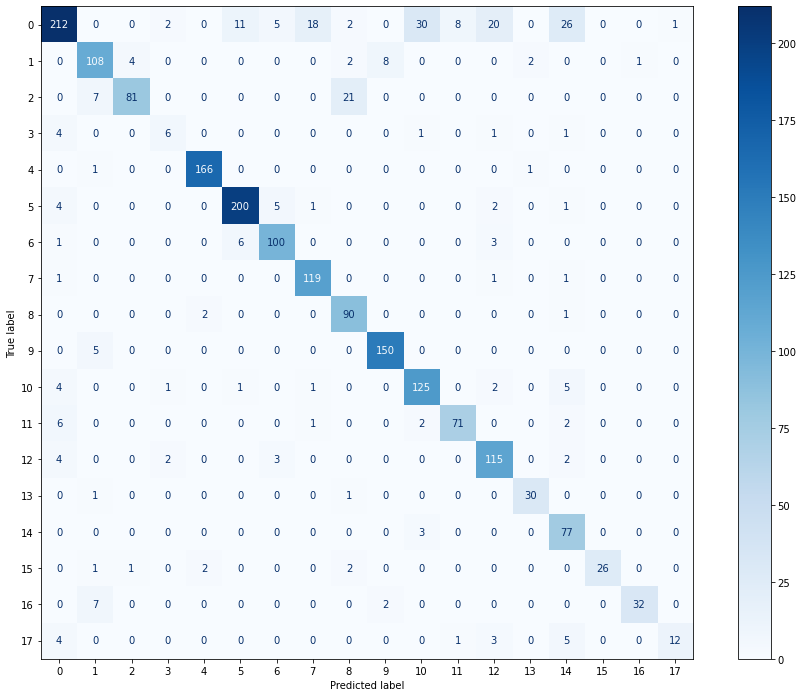

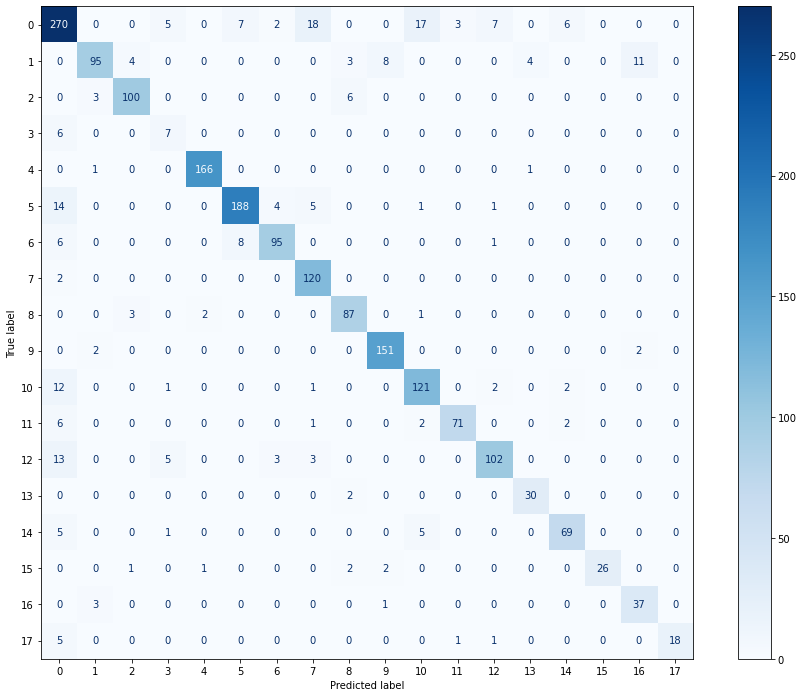

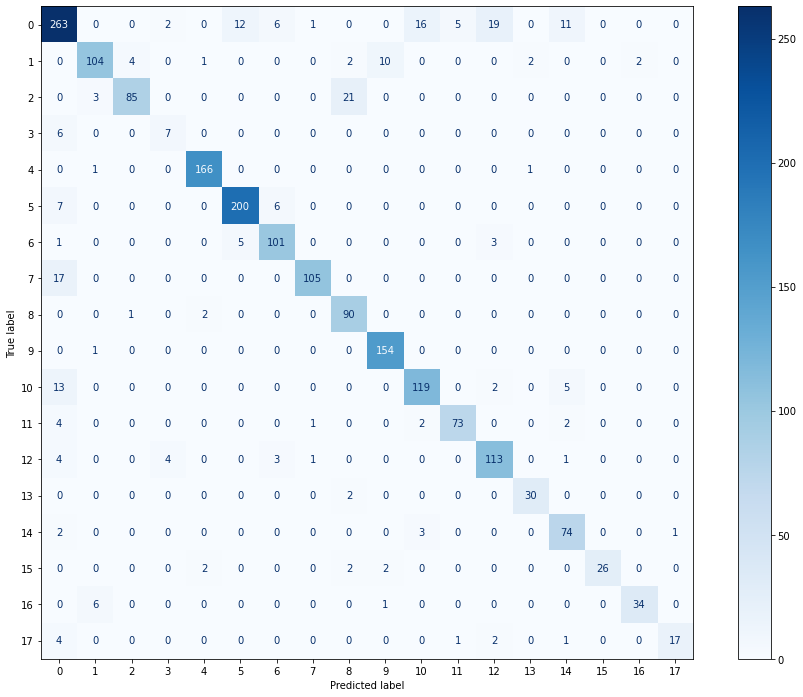

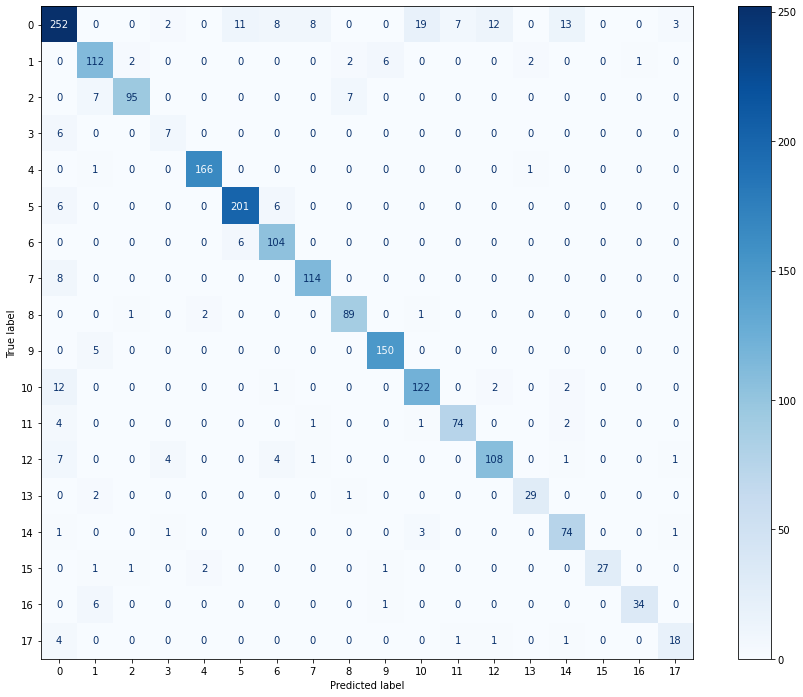

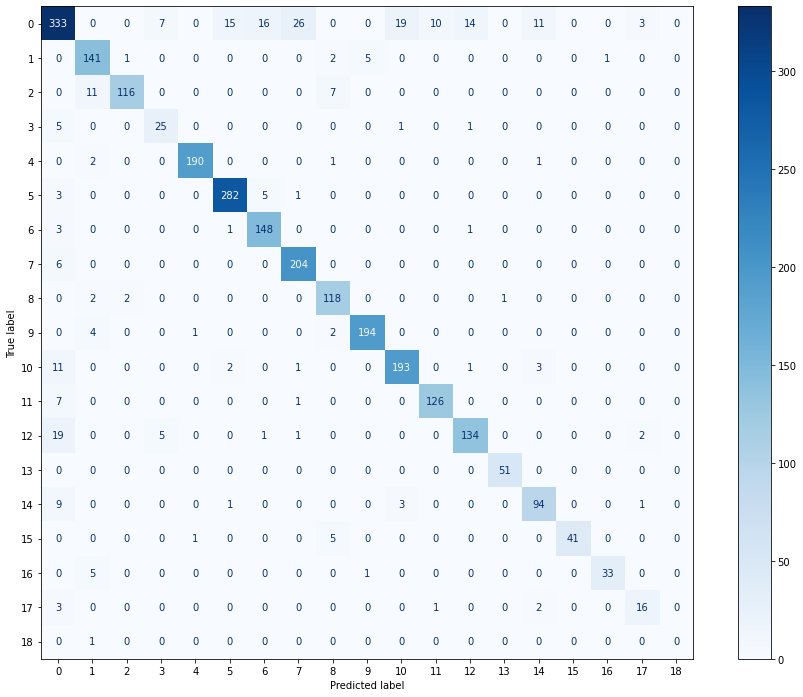

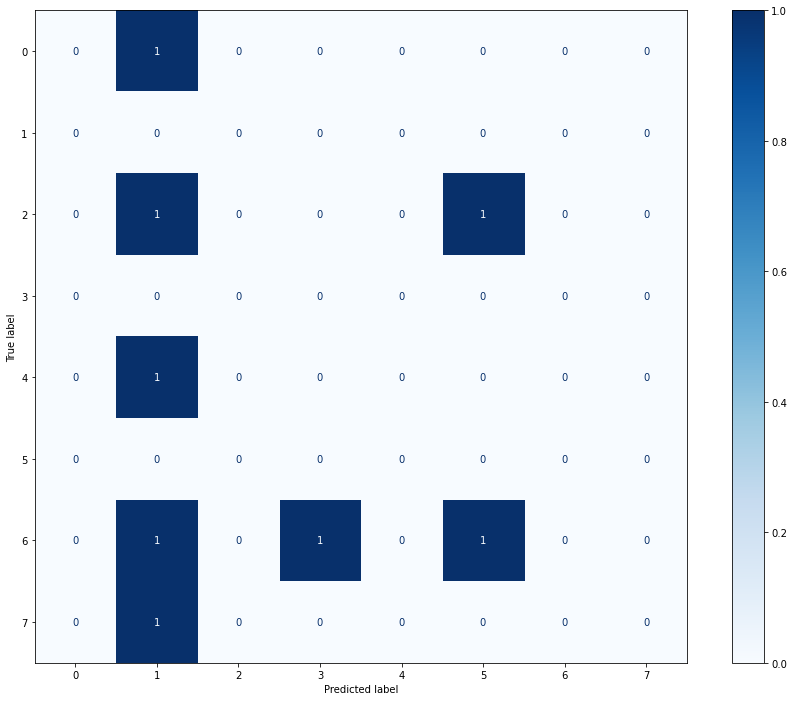

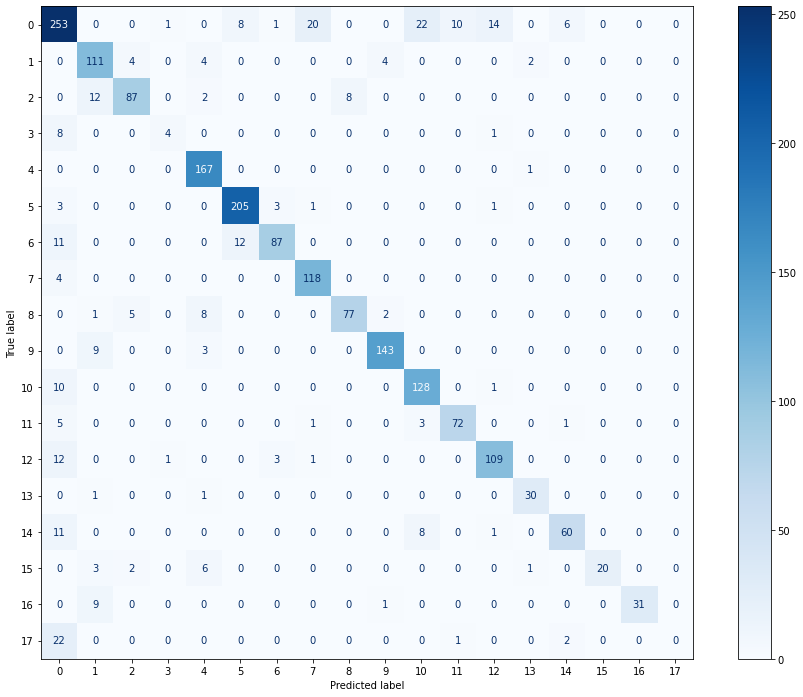

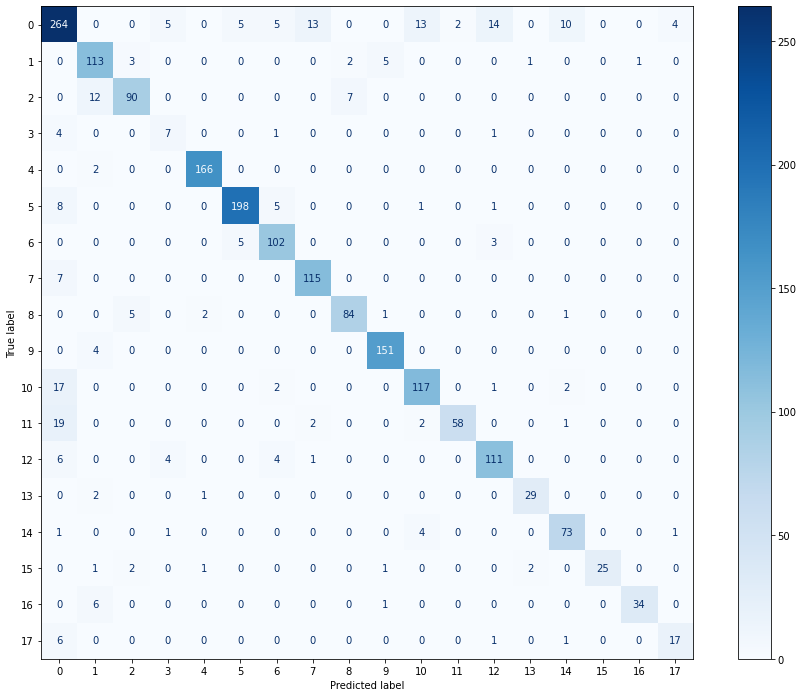

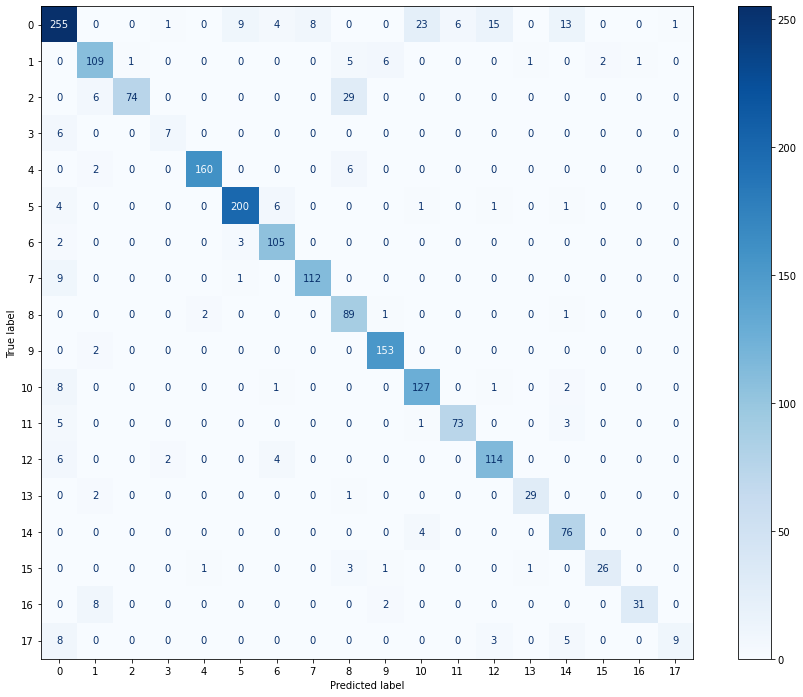

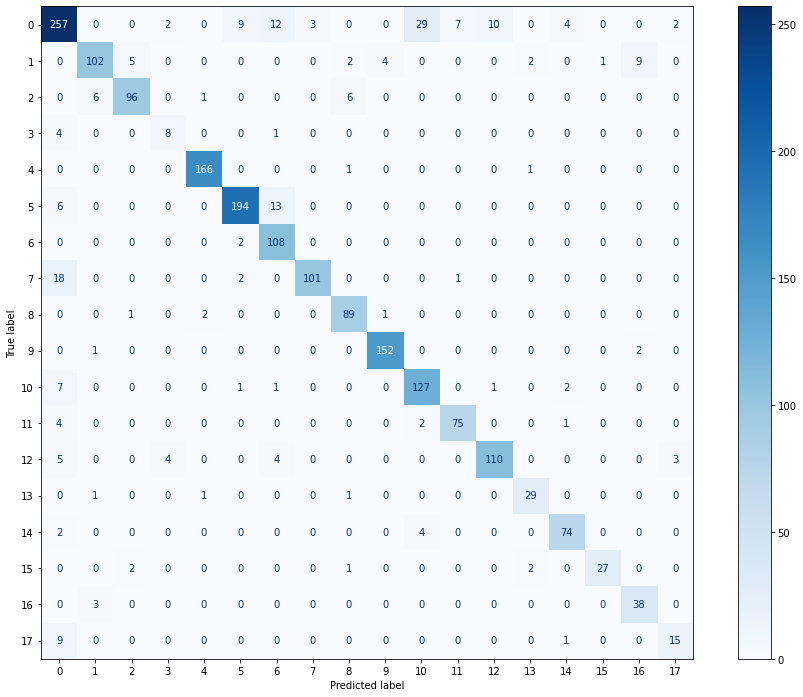

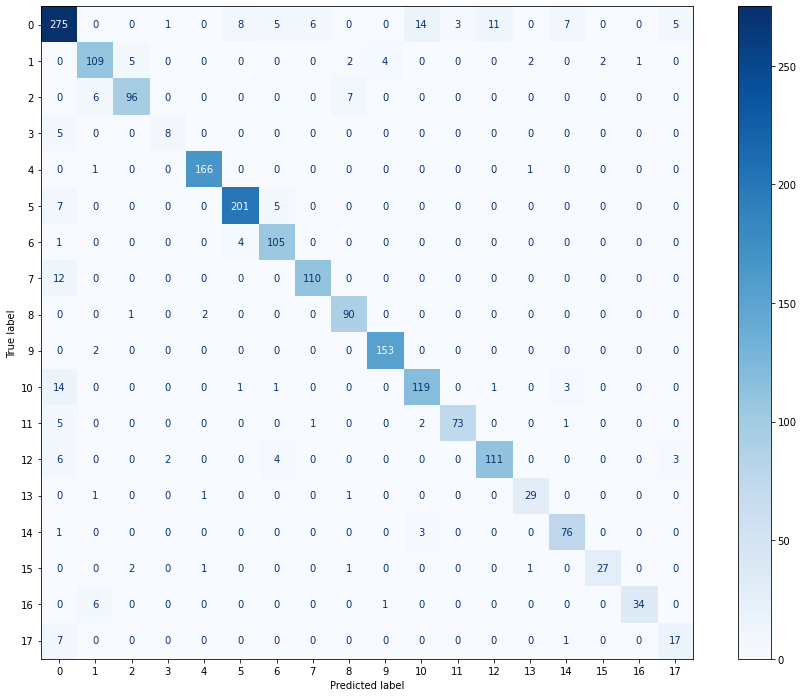

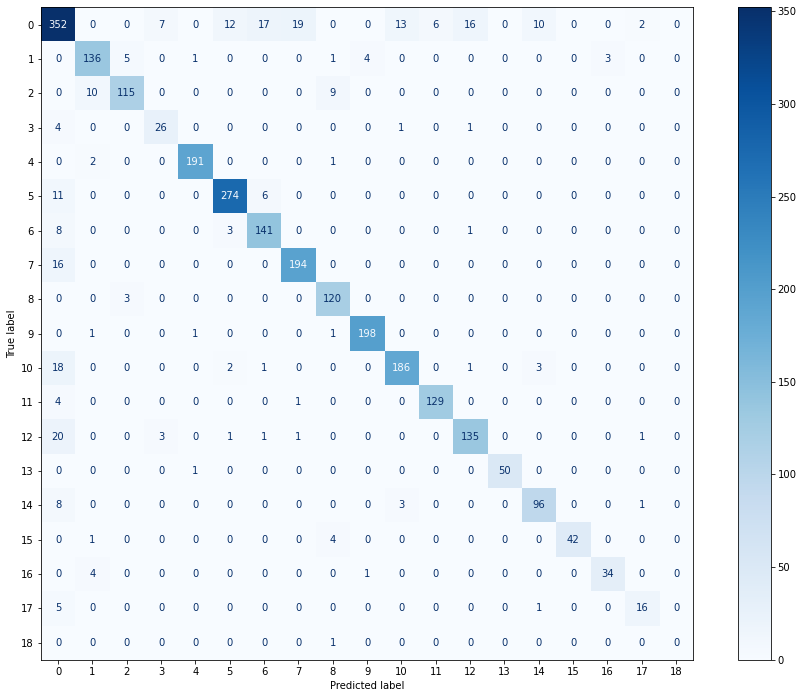

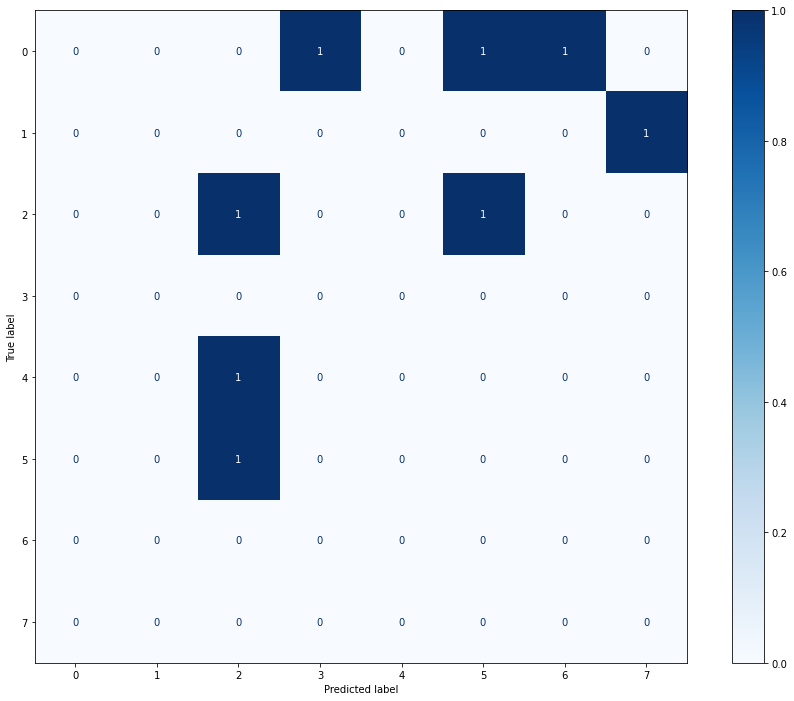

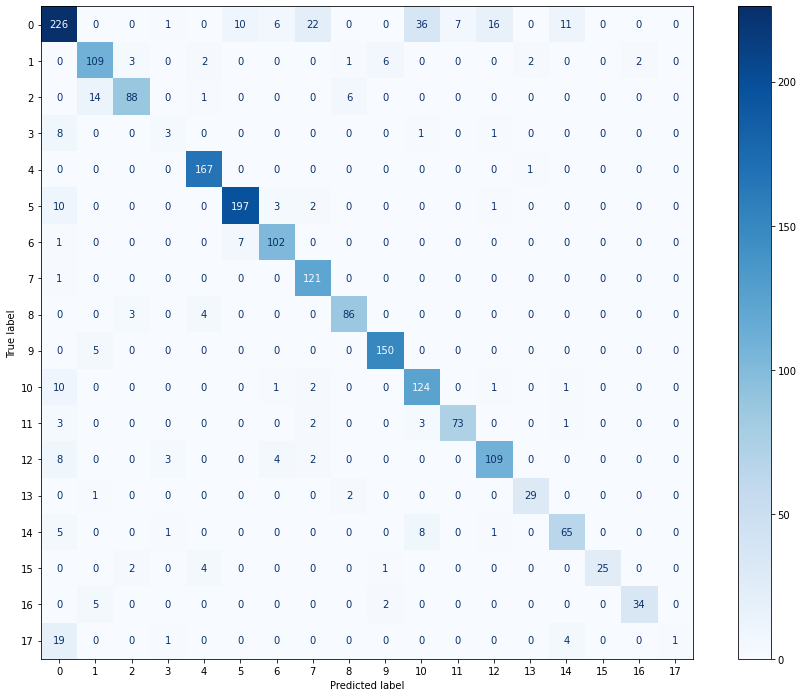

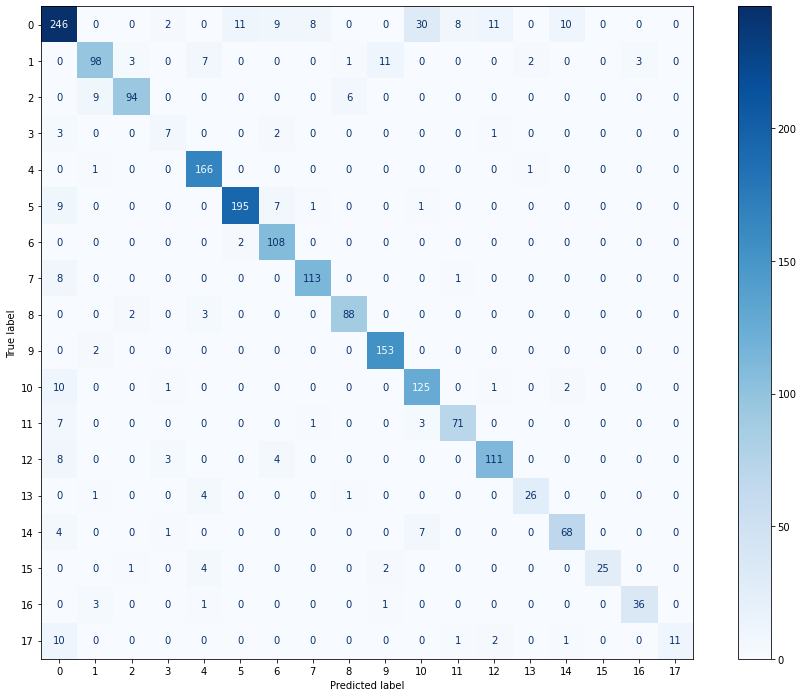

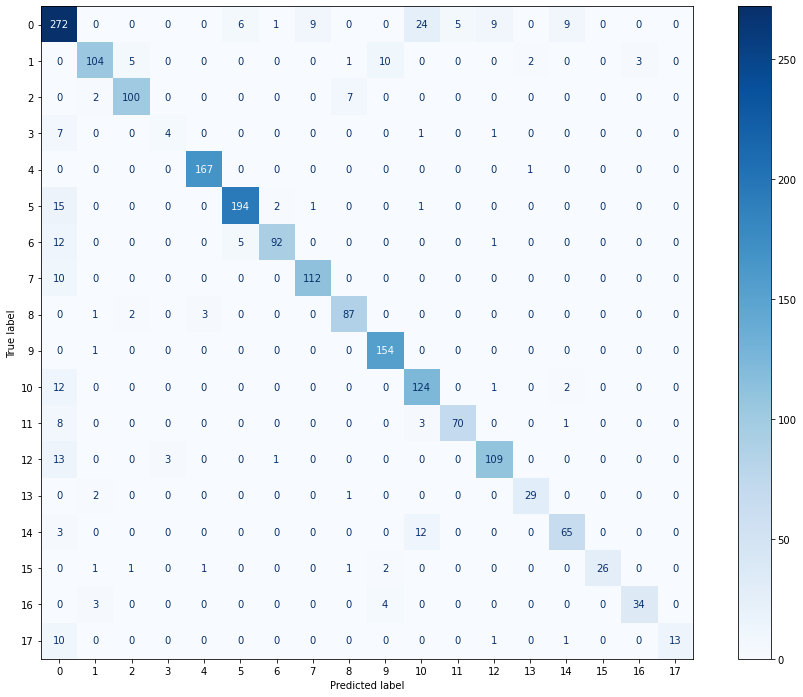

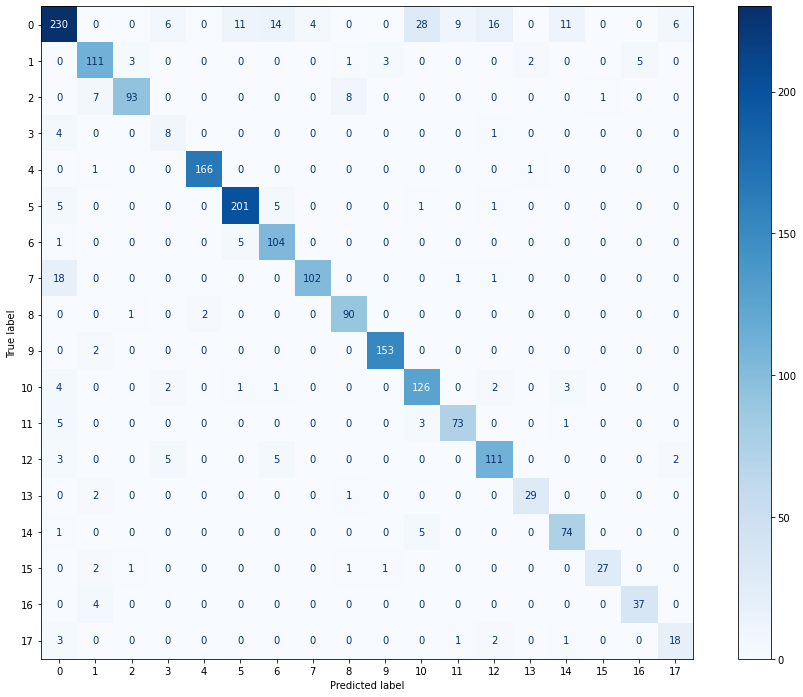

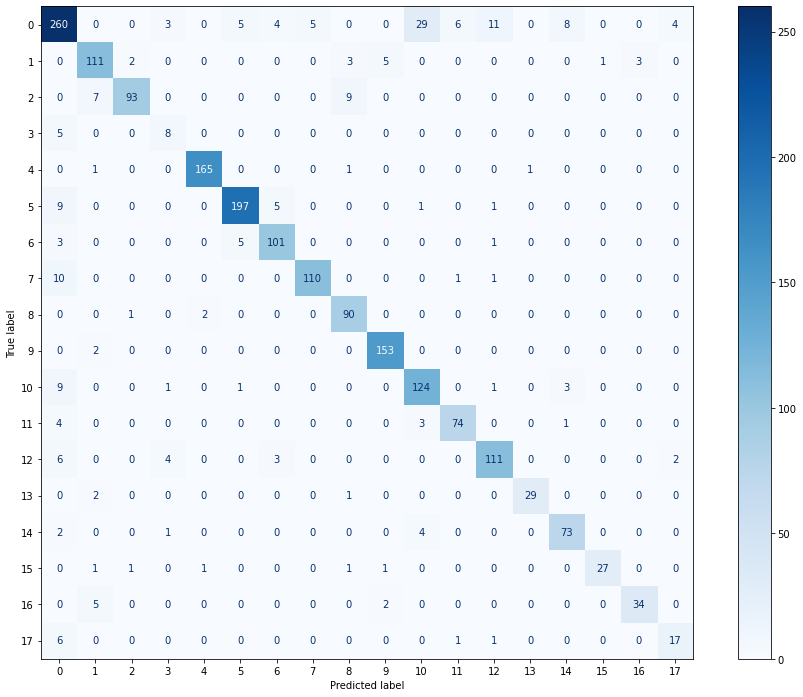

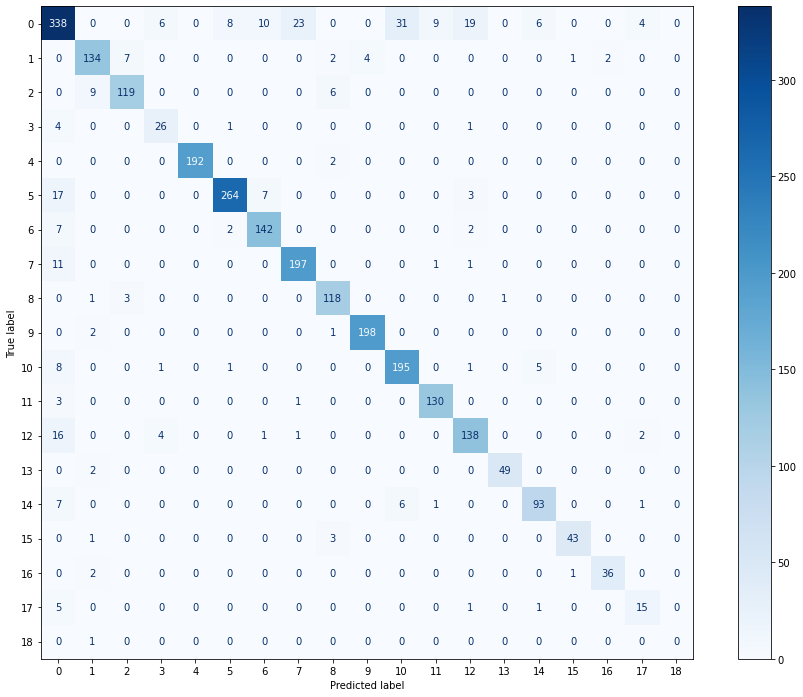

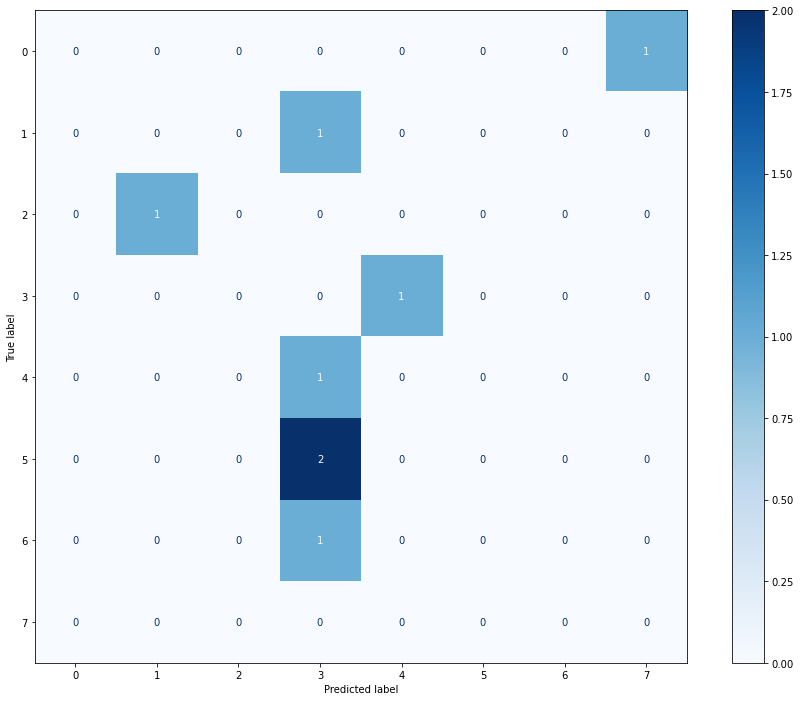

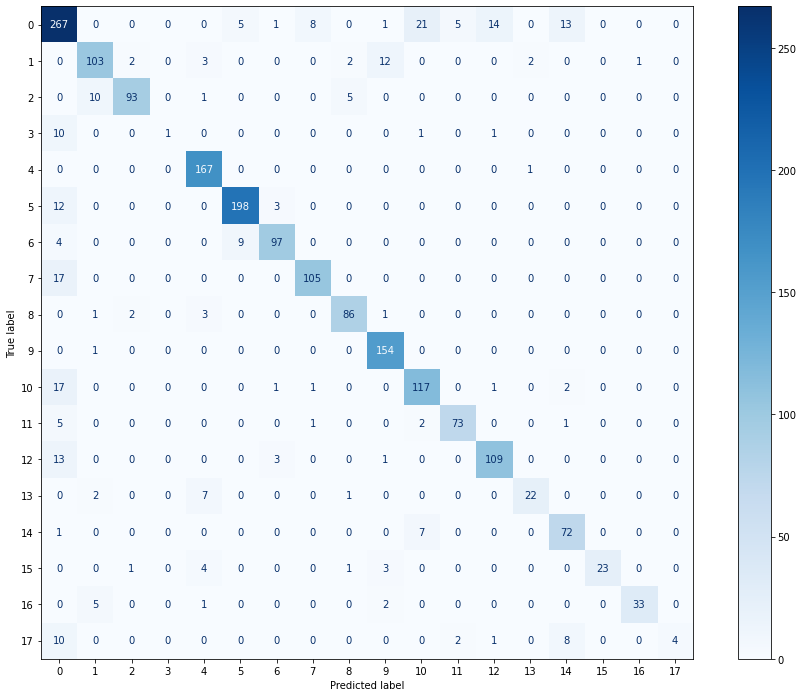

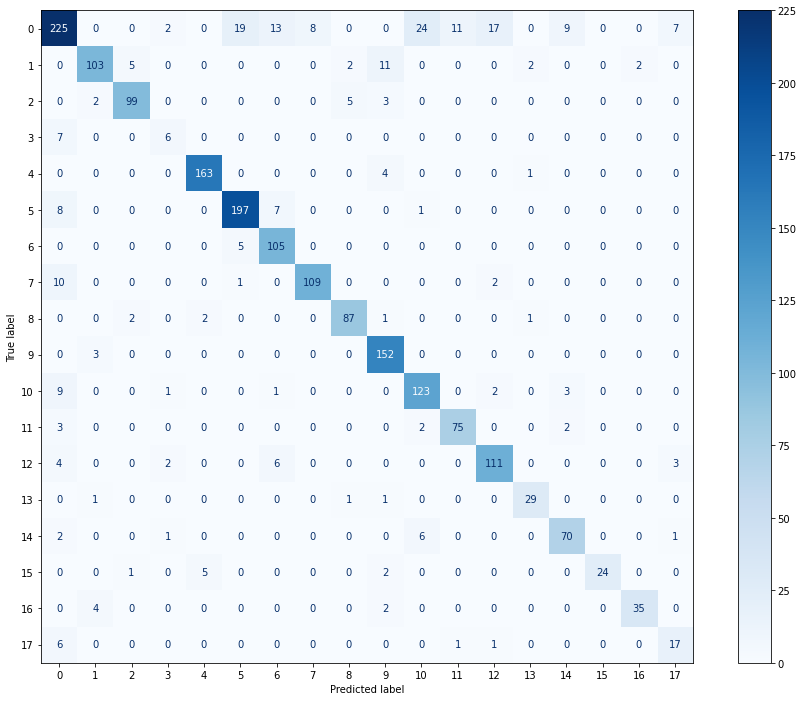

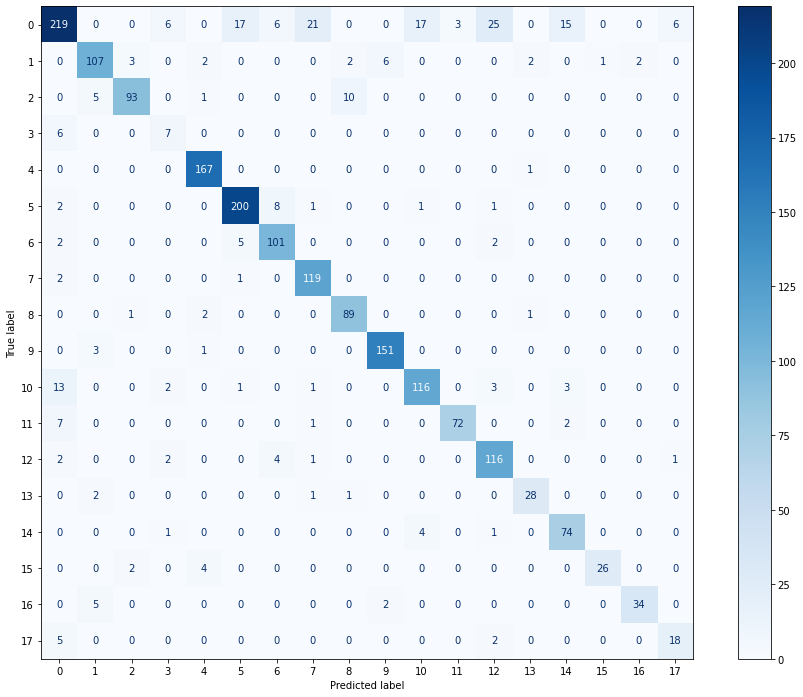

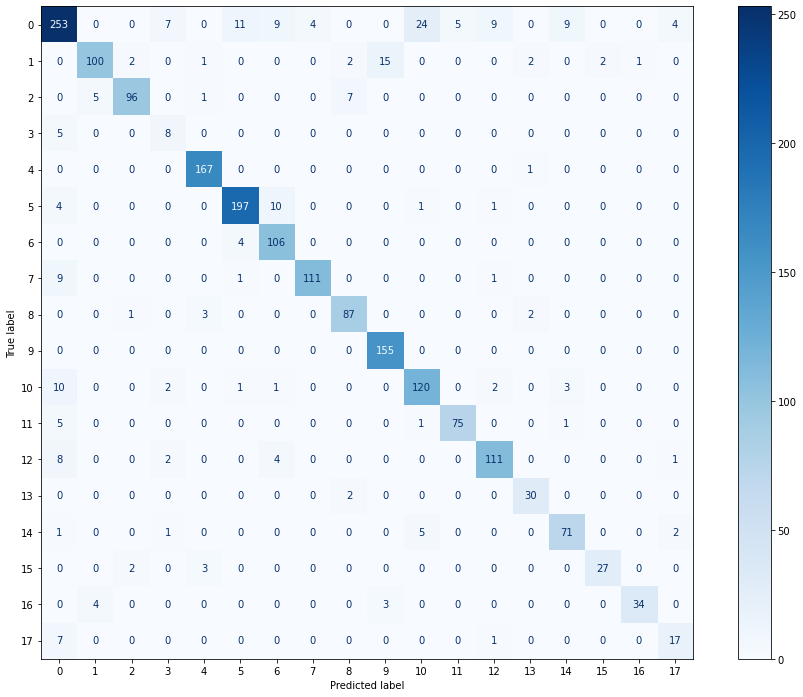

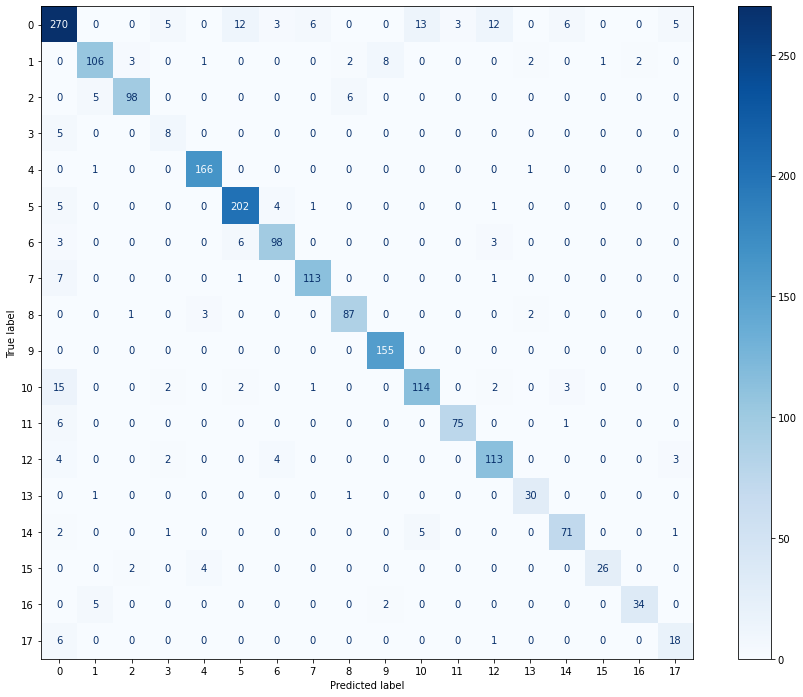

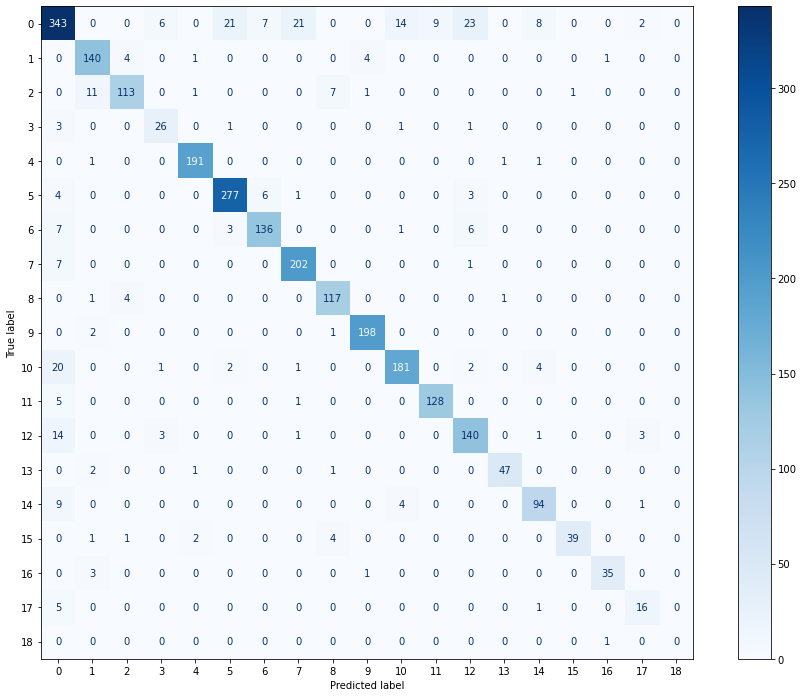

In [25]:
logger = NeptuneLogger(
    api_key=NEPTUNE_API_TOKEN,
    project_name=NEPTUNE_PROJECT_NAME,
    close_after_fit=False,
)

try:
    for i in range(4):
        print(f"--------- EXPERIMENT {i} ---------")

        classifier = trainer = None
        gc.collect()
        torch.cuda.empty_cache()

        trainer = LightningTrainer(
            gpus=GPUS,
            min_epochs=MIN_EPOCHS,
            max_epochs=MAX_EPOCHS,
            default_root_dir=CHECKPOINT_DIR,
            reload_dataloaders_every_epoch=True, # needed as we loop over a file,
            deterministic=False,
            checkpoint_callback=False,
            logger=logger
        )

        classifier = StandardClassifier(
            pretrained_language_model=PRETRAINED_MODEL,
            dataset_name=DATASET_NAME,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            decay_lr_speed=LEARNING_RATE_DECAY_SPEED,
            dropout_p=DROPOUT_P,
            activation_function=ACTIVATION_FUNCTION,
            weight_decay=WEIGHT_DECAY,
            linear_size=LINEAR_SIZE,
        )

        trainer.fit(classifier)
        trainer.test(classifier)

        scorer = get_official_scorer(i, logger)
        if scorer:
            scorer.score({
                'standard': classifier.test_proposed_answer,
            })
        else:
            print("No official scorer found")

except Exception as e:
    logger.experiment.stop(str(e))
    raise e

else:
    logger.experiment.stop()

## Training binary classifier

In [ ]:
GPUS = 1

BIN_MIN_EPOCHS = BIN_MAX_EPOCHS = 4 - 3

BIN_BATCH_SIZE = 8 + 56
BIN_LEARNING_RATE = 2e-05
BIN_LEARNING_RATE_DECAY_SPEED = [1, 1, 0.5, 0.25, 0.1, 0.1]

BIN_CLS_LINEAR_SIZE = 64
BIN_SUB_OBJ_LINEAR_SIZE = 32

BIN_DROPOUT_P = 0.2
BIN_ACTIVATION_FUNCTION = "PReLU"
BIN_WEIGHT_DECAY = 0.01 # default = 0.01


In [ ]:
bin_logger = NeptuneLogger(
    api_key=NEPTUNE_API_TOKEN,
    project_name=NEPTUNE_PROJECT_NAME,
    close_after_fit=False,
)

try:
    for i in range(1):
        print(f"--------- EXPERIMENT {i} ---------")
    
        bin_classifier = bin_trainer = None
        gc.collect()
        torch.cuda.empty_cache()
    
        bin_trainer = LightningTrainer(
            gpus=GPUS,
            min_epochs=BIN_MIN_EPOCHS,
            max_epochs=BIN_MAX_EPOCHS,
            default_root_dir=CHECKPOINT_DIR,
            reload_dataloaders_every_epoch=True, # needed as we loop over a file,
            deterministic=False,
            checkpoint_callback=False,
            logger=bin_logger,
        )
    
        bin_classifier = BinaryClassifier(
            pretrained_language_model=PRETRAINED_MODEL,
            dataset_name=DATASET_NAME,
            batch_size=BIN_BATCH_SIZE,
            learning_rate=BIN_LEARNING_RATE,
            decay_lr_speed=BIN_LEARNING_RATE_DECAY_SPEED,
            dropout_p=BIN_DROPOUT_P,
            activation_function=BIN_ACTIVATION_FUNCTION,
            weight_decay=BIN_WEIGHT_DECAY,
            cls_linear_size=BIN_CLS_LINEAR_SIZE,
            sub_obj_linear_size=BIN_SUB_OBJ_LINEAR_SIZE,
        )
    
        bin_trainer.fit(bin_classifier)
        bin_trainer.test(bin_classifier)

except Exception as e:
    bin_logger.experiment.stop(str(e))
    raise e

else:
    bin_logger.experiment.stop()
    

## Train relation classifier

In [ ]:
GPUS = 1
REL_MIN_EPOCHS = REL_MAX_EPOCHS = 5 - 4

REL_BATCH_SIZE = 8 + 56
REL_LEARNING_RATE = 2e-05
REL_LEARNING_RATE_DECAY_SPEED = [1, 1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01]

REL_CLS_LINEAR_SIZE = 64
REL_SUB_OBJ_LINEAR_SIZE = 32

REL_DROPOUT_P = 0.2
REL_ACTIVATION_FUNCTION = "PReLU"
REL_WEIGHT_DECAY = 0.01 # default = 0.01

In [ ]:
rel_logger = NeptuneLogger(
    api_key=NEPTUNE_API_TOKEN,
    project_name=NEPTUNE_PROJECT_NAME,
    close_after_fit=False,
)

try:
    for i in range(4-3):
        print(f"--------- EXPERIMENT {i} ---------")
    
        rel_classifier = rel_trainer = None
        gc.collect()
        torch.cuda.empty_cache()
    
        rel_trainer = LightningTrainer(
            gpus=GPUS,
            min_epochs=REL_MIN_EPOCHS,
            max_epochs=REL_MAX_EPOCHS,
            default_root_dir=CHECKPOINT_DIR,
            reload_dataloaders_every_epoch=True, # needed as we loop over a file,
            deterministic=False,
            checkpoint_callback=False,
            logger=logger
        )
    
        rel_classifier = RelationClassifier(
            pretrained_language_model=PRETRAINED_MODEL,
            dataset_name=DATASET_NAME,
            batch_size=REL_BATCH_SIZE,
            learning_rate=REL_LEARNING_RATE,
            decay_lr_speed=REL_LEARNING_RATE_DECAY_SPEED,
            dropout_p=REL_DROPOUT_P,
            activation_function=REL_ACTIVATION_FUNCTION,
            weight_decay=REL_WEIGHT_DECAY,
            cls_linear_size=REL_CLS_LINEAR_SIZE,
            sub_obj_linear_size=REL_SUB_OBJ_LINEAR_SIZE,
        )
    
        rel_trainer.fit(rel_classifier)
        rel_trainer.test(rel_classifier)

except Exception as e:
    rel_logger.experiment.stop(str(e))
    raise e

else:
    rel_logger.experiment.stop()

## Train 2 classifiers independently then test together

In [ ]:
def test_together(experiment_no: int, logger, b_classifier: BinaryClassifier, r_classifier: RelationClassifier, dataset_name: str = DATASET_NAME,
                  bin_batch_size = BIN_BATCH_SIZE, batch_size: int = REL_BATCH_SIZE):
    
    b_classifier.freeze()
    r_classifier.freeze()

    true_answer = []

    # run binary classifier
    print("Running binary classifier")
    dataset = GenericDataset(dataset_name, subset='test', batch_size=bin_batch_size, label_transform='none')
    binary_classify_results = { criteria: [] for criteria in b_classifier.thresholds.keys() }

    for input_data, true_label  in tqdm(dataset.as_batches(), total=len(dataset)):
        # append true answers
        true_answer += true_label.tolist()

        # run bin classifier
        logits = b_classifier(**input_data)
        y_hat = torch.sigmoid(logits)
        for criteria, threshold in b_classifier.thresholds.items():
            label = b_classifier.yhat_to_label(y_hat, threshold)
            binary_classify_results[criteria] += label.tolist()

    # run relation classifier
    print("Running relation classifier")
    dataset = GenericDataset(dataset_name, subset='test', batch_size=batch_size, label_transform='none')
    relation_classify_result = []

    for input_data, true_label  in tqdm(dataset.as_batches(), total=len(dataset)):
        logits = r_classifier(**input_data)
        label = r_classifier.logits_to_label(logits) + 1
        relation_classify_result += label.tolist()

    # combine results
    print("Combining results")
    proposed_answer = {}
    for criteria in b_classifier.thresholds.keys():
        results = zip(relation_classify_result, binary_classify_results[criteria])
        final_label = [relation_result if bin_result else 0 for relation_result, bin_result in results]
        proposed_answer[criteria] = final_label

    # log metric
    final_metrics = {}
    for criteria in b_classifier.thresholds.keys():
        pa = proposed_answer[criteria]
        
        final_metrics.update({
            f'test_combined_{criteria}_acc': accuracy_score(true_answer, pa),
            f'test_combined_{criteria}_pre_micro': precision_score(true_answer, pa, average='micro'),
            f'test_combined_{criteria}_rec_micro': recall_score(true_answer, pa, average='micro'),
            f'test_combined_{criteria}_f1_micro': f1_score(true_answer, pa, average='micro'),
            f'test_combined_{criteria}_pre_macro': precision_score(true_answer, pa, average='macro'),
            f'test_combined_{criteria}_rec_macro': recall_score(true_answer, pa, average='macro'),
            f'test_combined_{criteria}_f1_macro': f1_score(true_answer, pa, average='macro'),
        })
        
        fig = BaseClassifier.plot_confusion_matrix(pa, true_answer)
        logger.experiment.log_image(f"test_combined_{criteria}_confusion_matrix", fig)

    for k, v in final_metrics.items():
        print(f"{k}: {v * 100}")

    for k, v in final_metrics.items():
        logger.experiment.log_metric(k, v)
    
    # run the offical scorer
    scorer = get_official_scorer(experiment_no, logger)
    if scorer:
        scorer.score(proposed_answer)
    else:
        print("No official scorer found")

In [ ]:
combine_logger = NeptuneLogger(
    api_key=NEPTUNE_API_TOKEN,
    project_name=NEPTUNE_PROJECT_NAME,
    close_after_fit=False,
)

try:
    for i in range(1):
        print(f"--------- EXPERIMENT {i} ---------")
    
        # clean up
        bin_classifier = bin_trainer = rel_classifier = rel_trainer = None
        gc.collect()
        torch.cuda.empty_cache()
    
        # relation classifier
        rel_trainer = LightningTrainer(
            gpus=GPUS,
            min_epochs=REL_MIN_EPOCHS,
            max_epochs=REL_MAX_EPOCHS,
            default_root_dir=CHECKPOINT_DIR,
            reload_dataloaders_every_epoch=True, # needed as we loop over a file,
            deterministic=False,
            checkpoint_callback=False,
            logger=combine_logger
        )
        rel_classifier = RelationClassifier(
            pretrained_language_model=PRETRAINED_MODEL,
            dataset_name=DATASET_NAME,
            batch_size=REL_BATCH_SIZE,
            learning_rate=REL_LEARNING_RATE,
            decay_lr_speed=REL_LEARNING_RATE_DECAY_SPEED,
            dropout_p=REL_DROPOUT_P,
            activation_function=REL_ACTIVATION_FUNCTION,
            weight_decay=REL_WEIGHT_DECAY,
            cls_linear_size=REL_CLS_LINEAR_SIZE,
            sub_obj_linear_size=REL_SUB_OBJ_LINEAR_SIZE,
        )
        rel_trainer.fit(rel_classifier)
    
        # binary classifier
        bin_trainer = LightningTrainer(
            gpus=GPUS,
            min_epochs=BIN_MIN_EPOCHS,
            max_epochs=BIN_MAX_EPOCHS,
            default_root_dir=CHECKPOINT_DIR,
            reload_dataloaders_every_epoch=True, # needed as we loop over a file,
            deterministic=False,
            checkpoint_callback=False,
            logger=combine_logger,
        )
        bin_classifier = BinaryClassifier(
            pretrained_language_model=PRETRAINED_MODEL,
            dataset_name=DATASET_NAME,
            batch_size=BIN_BATCH_SIZE,
            learning_rate=BIN_LEARNING_RATE,
            decay_lr_speed=BIN_LEARNING_RATE_DECAY_SPEED,
            dropout_p=BIN_DROPOUT_P,
            activation_function=BIN_ACTIVATION_FUNCTION,
            weight_decay=BIN_WEIGHT_DECAY,
            cls_linear_size=BIN_CLS_LINEAR_SIZE,
            sub_obj_linear_size=BIN_SUB_OBJ_LINEAR_SIZE,
        )
        bin_trainer.fit(bin_classifier)
        
        # test together
        test_together(i, combine_logger, bin_classifier, rel_classifier)

except Exception as e:
    combine_logger.experiment.stop(str(e))
    raise e

else:
    combine_logger.experiment.stop()